In [3]:
import pickle
import os
import fnmatch
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.transforms as mtransforms
import time
from mpl_toolkits import mplot3d
import seaborn as sns
from math import ceil
import re

In [4]:
def BER(N,p,eng_list):
    ber = 0
    p = np.array(p)
    
    for k in range(len(p)):
        if k+1< len(p):
            ber += (np.sum(p[k:])**N - np.sum(p[k+1:])**N)*eng_list[k]
        else:
            ber += p[k]**N * eng_list[k]
    return np.round(ber,8)

def cumulative(energy, p, eng_list):
    # energy is the energy threshold
    cumulative_dist = np.cumsum(p)
    if min(eng_list) > energy:
        return 0
    elif max(eng_list) < energy:
        return 1
    
    for i, E in enumerate(eng_list):
        
        if E > energy:
            return cumulative_dist[i-1]

    return 1

def confidence_prob(N, p, eng_list, eng_th):
    F = cumulative(eng_th , p, eng_list)
    
    return 1-(1-F)**N

def invCDF(N, prob, eng_list, conf = 0.99):
    cdf = np.cumsum(prob)    
    threshold = 1 - (1-conf)**(1/N)
    for idx, p in enumerate(cdf):
        
        if p >= threshold:
            if idx ==0:
                return eng_list[0]
            else:
                return eng_list[idx]
            
def failure_prob(N, p, eng_list, eng_th):
    F = cumulative(eng_th , p, eng_list)
    
    return (1-F)**N

def runs(Eth, conf, prob, eng_list ):
    F = cumulative(Eth, prob, eng_list)
    if F == 1:
        return 1
    else:
        return np.log(1-conf)/np.log(1-F)

In [5]:
def tts_threshold(prob, eng_center, p0, thresholds, p_th):
#     prob, eng_center, p0 = key_reader(NQ, key)
#     Emin = threshold[0]
    n = {idx : 0 for idx in range(4)}
    if thresholds[1] < eng_center[0]:
        n = {idx : 9999999 for idx in range(4)}
        return n
    else:
        for k, Eth in enumerate(thresholds):
            if k == 0 and p0 != 0:
                N = np.log(1-p_th)/np.log(1-p0)
                n[k] += N

            elif k < 4:
                F = cumulative(Eth , prob, eng_center)
                if F == 0:
                    N = 0
                elif F < 1/30000:
                    N = 150000
                elif F == 1:
                    N = 1
                    n[k] += N
                else:
                    N = np.round(np.log(1-p_th)/np.log(1-F),3)
                    n[k] += N
    return n


def exp_eng_thresholds(prob, eng_center, thresholds, step = 10, N = 1):

    flag = False
    flag_1 = False
#     n1 = []
#     n5 = []
    E = 1000
    
    if thresholds[1] < eng_center[0]:
        n01 = 9999999
        n1 = 9999999
        n5 = 9999999
    else:
        while E > thresholds[1]:
    #     while E > thresholds[0]:

            E = BER(N, prob, eng_center)

            if E <= thresholds[3] and not flag:
    #             n5.append(N)
                n5 = N
                flag = True
            if E <= thresholds[2] and not flag_1:
                n1 = N
                flag_1 = True
    #             n1.append(N)
            if E <= thresholds[1]:
                n01 = N
    #             print("we reached, N = ", N, ", Eber = ", E, ", thresholds = ", thresholds)
    #         N += step

            if N > 150000:
                print(", N = ", N, ", Eber = ", E, ", thresholds = ", thresholds)

                if E > thresholds[3]:
    #                 n5.append(N)
    #                 n1.append(N)
                    n5 = N
                    n1 = N
                    n01 = N
                elif E > thresholds[2]:
    #                 n1.append(N)
                    n1 = N
                    n01 = N
                elif E > thresholds[1]:
                    n01 = N
                break
            N += step
    n = {0 : n01, 1 : n1, 2 : n5}
    return n
                

In [6]:
def plot_difficulty():
    NQ = 44
    path = "data_for_plots/"
    
    df_exp_01 = pd.read_csv(path + "Exp_eng_01_p_th=0.99_step=1_new.csv", index_col = 0)
    df_exp_01_stoch = pd.read_csv(path + "Exp_eng_01_p_th=0.99_step=1_stoch_only.csv", index_col = 0)
    df_tts_01 = pd.read_csv(path + "TTS_01_p_th=0.99_step=1.csv", index_col = 0)  
    df_tts_1 = pd.read_csv(path + "TTS_5_p_th=0.99_step=1.csv", index_col = 0) 

    problems = list(range(1,21))
    N_tts = ast.literal_eval(df_tts_01[str(NQ)].values[-1])
    N_tts_1 = ast.literal_eval(df_tts_1[str(NQ)].values[-1])
    N_exp = df_exp_01_stoch[str(NQ)].values
    
    print(len(problems), len(N_tts))
    path = "plots/"
    if not os.path.exists(path):
        os.makedirs(path)
        
    font_size = 35
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = font_size)
    ax.tick_params(axis='x',labelsize = font_size)
    
    title = "hardness_tts_hist_NQ="+str(NQ) 
    
#     fig.suptitle(title, fontsize = font_size)
#     ax.bar(problems, N_tts, color='xkcd:bright blue', label = "TTS 0.1%")
#     ax.bar(problems, N_tts_1, color='xkcd:bright purple', label = "TTS 1%")
    ax.hist(N_tts, bins = 20,color='xkcd:bright blue', label = "TTS 0.1%", align = "mid", rwidth = 0.8)
#     ax.hist(N_tts_1, bins = 20,color='xkcd:bright purple', label = "TTS 1%", align = "mid", rwidth = 0.8)
#     plt.yticks(list(range(11)))
#     plt.xticks(list(range(1,21)))
    ax.grid(True)
    
    ax.set_xlabel('Cost (# of Runs)', fontsize = font_size)
    ax.set_ylabel("Occurrences",  fontsize = font_size)
    fig.legend(loc=(0.75, 0.75), prop = {"size" : font_size-5} )
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 
    
    plt.show()
    plt.close(fig)

20 20


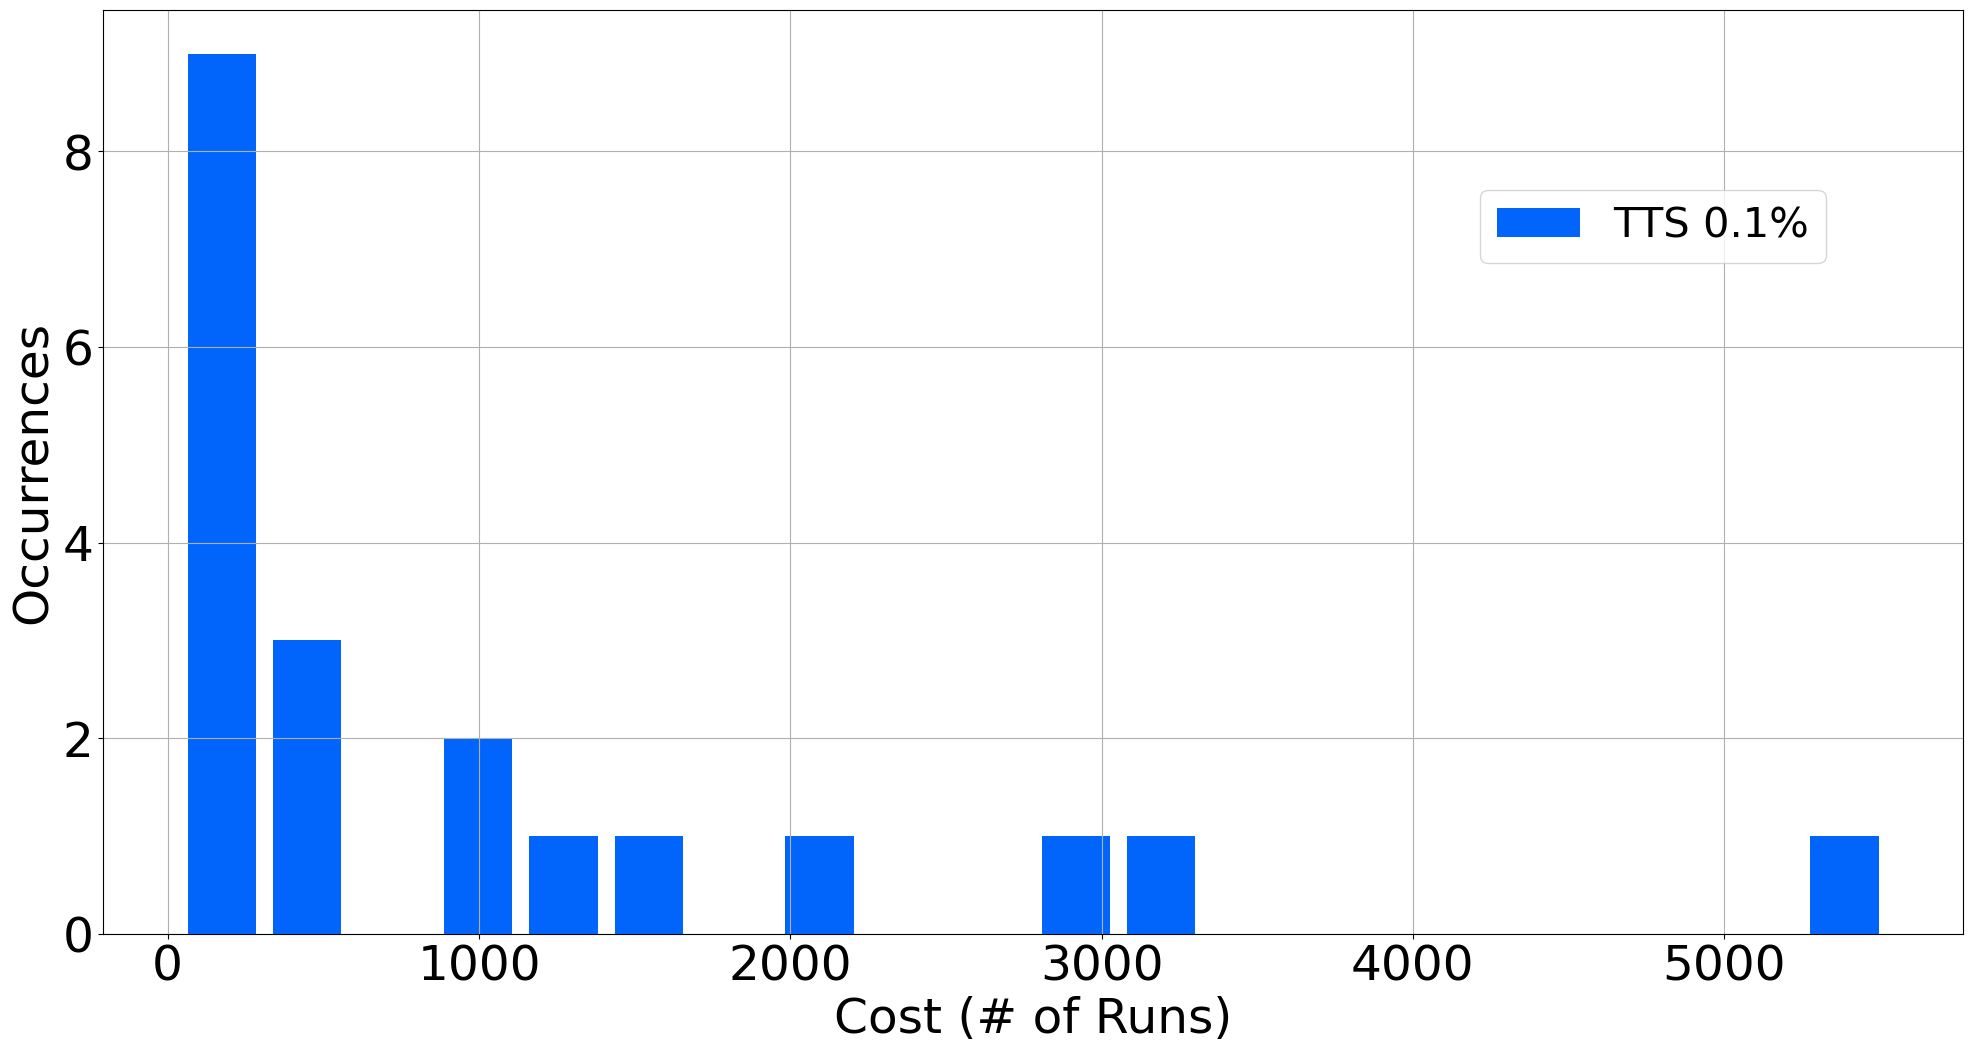

In [7]:
plot_difficulty()

In [24]:
def plot_overheads_stoch_elite():    
    path = "data_for_plots/"
    
    df_stoch = pd.read_csv(path + "time_stoch_p_th=0.99.csv", index_col = 0)
    df_elite = pd.read_csv(path + "time_elite_p_th=0.99.csv", index_col = 0)
    
    df_exp_01 = pd.read_csv(path + "Exp_eng_01_p_th=0.99_step=1_new.csv", index_col = 0)
    df_exp_01_stoch = pd.read_csv(path + "Exp_eng_01_p_th=0.99_step=1_stoch_only.csv", index_col = 0)
    df_tts_01 = pd.read_csv(path + "TTS_01_p_th=0.99_step=1.csv", index_col = 0)
        
    names = ["stoch", "elite", "opt", "avg"]
    styles = ["mean", "median", "std", "min", "max"]

    mean_stoch = []
    median_stoch = []
    std_stoch = []
    min_stoch = []
    max_stoch = []
       
    mean_elite = []
    median_elite = []
    std_elite = []
    min_elite = []
    max_elite = []
    
    N_tts = {name : {style : [] for style in styles} for name in names } 
    N_exp = {name : {style : [] for style in styles} for name in names }

    NQ_list = []
    for nq in range(12, 45,4):
        NQ_list.append(nq)
        data_stoch = df_stoch[str(nq)].values * 10**6
        data_elite = df_elite[str(nq)].values* 10**6

        mean_stoch.append(np.mean(data_stoch))
        median_stoch.append(np.median(data_stoch))
        std_stoch.append(np.std(data_stoch))
        min_stoch.append(np.min(data_stoch))
        max_stoch.append(np.max(data_stoch))

        mean_elite.append(np.mean(data_elite))
        median_elite.append(np.median(data_elite))
        std_elite.append(np.std(data_elite))
        min_elite.append(np.min(data_elite))
        max_elite.append(np.max(data_elite))
        
        for method in names:
            
            N_tts_01 = ast.literal_eval(df_tts_01[str(nq)][method])
            if method == "stoch":
                N_exp_01 = df_exp_01_stoch[str(nq)].values
            else:
                N_exp_01 = ast.literal_eval(df_exp_01[str(nq)][method])

            for metric in styles:
                if metric == "mean":
                    N_t_01 = np.mean(N_tts_01)
                    N_e_01 = np.mean(N_exp_01)
                elif metric == "median":
                    N_t_01 = np.median(N_tts_01)
                    N_e_01 = np.median(N_exp_01)
                elif metric == "std":
                    N_t_01 = np.std(N_tts_01)
                    N_e_01 = np.std(N_exp_01)
                elif metric == "min":
#                     N_t_01 = np.min(N_tts_01)
#                     N_e_01 = np.min(N_exp_01)
                    N_t_01 = np.quantile(N_tts_01, 0.35)
                    N_e_01 = np.quantile(N_exp_01, 0.35)             
                    if N_t_01 == 0 or N_e_01 ==0:
                        print("NQ = ",nq, ", TTS = ", N_t_01, ", EXP = ", N_e_01)
                elif metric == "max":
#                     N_t_01 = np.max(N_tts_01)
#                     N_e_01 = np.max(N_exp_01)
                    N_t_01 = np.quantile(N_tts_01, 0.65)
                    N_e_01 = np.quantile(N_exp_01, 0.65)     
                    if N_t_01 == 0 or N_e_01 ==0:
                        print("NQ = ",nq, ", TTS = ", N_t_01, ", EXP = ", N_e_01)
                N_tts[method][metric].append(N_t_01)

                N_exp[method][metric].append(N_e_01)

        
    path = "plots/avg_all_method/"
    if not os.path.exists(path):
        os.makedirs(path)


    
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    title = "lin_log_exp_median_top=01_step=1_p_th=99_errorbars=min_max_overhead" 
    
    fig.suptitle(title, fontsize = 25)
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["avg"]["median"])*2),"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)

    ax.errorbar(NQ_list, np.log10(np.array(N_exp["avg"]["median"])*2), yerr = [np.log10(np.array(N_exp["avg"]["min"])*2),np.log10(np.array(N_exp["avg"]["max"])*2)], color='xkcd:bright blue',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["opt"]["median"])*2), yerr = [np.log10(np.array(N_exp["opt"]["min"])*2),np.log10(np.array(N_exp["opt"]["max"])*2)], color='xkcd:bright purple',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["stoch"]["median"])*2+2 * 273*100), yerr = [np.log10(np.array(N_exp["stoch"]["min"])*2),np.log10(np.array(N_exp["stoch"]["max"])*2)], color='xkcd:kelly green',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["elite"]["median"])*2+2 * 273*100), yerr = [np.log10(np.array(N_exp["elite"]["min"])*2),np.log10(np.array(N_exp["elite"]["max"])*2)], color='xkcd:dark orange',capsize = 2, elinewidth = 2, capthick= 2)
    
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["opt"]["median"])*2),"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["stoch"]["median"])*2+2 * 273*100),"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_exp["elite"]["median"])*2+2 * 273*100),"-o", color='xkcd:dark orange', label = "EM", markersize = 15)

    
    ax.grid(True)
#     ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$"]
    ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$", r"$10^{10}$", r"$10^{11}$"]
    plt.yticks(list(range(12)))
    plt.xticks(list(range(12,45,4)))
    ax.set_yticklabels(ticks_y, minor = False)
    ax.set_xlabel('#Qubits', fontsize = 25)
    ax.set_ylabel("Time " + r"$[\mu s]$",  fontsize = 25)
    fig.legend(loc=(0.1, 0.8))
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 
    
    
#     plt.show()
    plt.close(fig)
    

    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    title = "lin_log_tts_median_top=01_step=1_p_th=99_errorbars=min_max_overhead" 
    
    fig.suptitle(title, fontsize = 25)
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["avg"]["median"])*2),"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)

    ax.errorbar(NQ_list, np.log10(np.array(N_tts["avg"]["median"])*2), yerr = [np.log10(np.array(N_tts["avg"]["min"])*2),np.log10(np.array(N_tts["avg"]["max"])*2)], color='xkcd:bright blue',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["opt"]["median"])*2), yerr = [np.log10(np.array(N_tts["opt"]["min"])*2),np.log10(np.array(N_tts["opt"]["max"])*2)], color='xkcd:bright purple',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["stoch"]["median"])*2+2 * 273*100), yerr = [np.log10(np.array(N_tts["stoch"]["min"])*2),np.log10(np.array(N_tts["stoch"]["max"])*2)], color='xkcd:kelly green',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["elite"]["median"])*2+2 * 273*100), yerr = [np.log10(np.array(N_tts["elite"]["min"])*2),np.log10(np.array(N_tts["elite"]["max"])*2)], color='xkcd:dark orange',capsize = 20, elinewidth = 2, capthick= 2)
    
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["opt"]["median"])*2),"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["stoch"]["median"])*2+2 * 273*100),"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_tts["elite"]["median"])*2+2 * 273*100),"-o", color='xkcd:dark orange', label = "EM", markersize = 15)

    
    ax.grid(True)
    ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$", r"$10^{10}$", r"$10^{11}$"]
    plt.yticks(list(range(12)))
    plt.xticks(list(range(12,45,4)))
    ax.set_yticklabels(ticks_y, minor = False)
    ax.set_xlabel('#Qubits', fontsize = 25)
    ax.set_ylabel("Time " + r"$[\mu s]$",  fontsize = 25)
    fig.legend(loc=(0.1, 0.8))
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 

    
#     plt.show()
    plt.close(fig)
    
    
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    title = "lin_log_exp_median_top=01_step=1_p_th=99_errorbars=min_max_no_overhead" 
    
    fig.suptitle(title, fontsize = 25)
    
    

    ax.errorbar(NQ_list, np.log10(np.array(N_exp["avg"]["median"])*2), yerr = [np.log10(np.array(N_exp["avg"]["min"])*2),np.log10(np.array(N_exp["avg"]["max"])*2)], color='xkcd:bright blue',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["opt"]["median"])*2), yerr = [np.log10(np.array(N_exp["opt"]["min"])*2),np.log10(np.array(N_exp["opt"]["max"])*2)], color='xkcd:bright purple',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["stoch"]["median"])*2), yerr = [np.log10(np.array(N_exp["stoch"]["min"])*2),np.log10(np.array(N_exp["stoch"]["max"])*2)], color='xkcd:kelly green',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["elite"]["median"])*2), yerr = [np.log10(np.array(N_exp["elite"]["min"])*2),np.log10(np.array(N_exp["elite"]["max"])*2)], color='xkcd:dark orange',capsize = 2, elinewidth = 2, capthick= 2)
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["avg"]["median"])*2),"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_exp["opt"]["median"])*2),"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["stoch"]["median"])*2),"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_exp["elite"]["median"])*2),"-o", color='xkcd:dark orange', label = "EM", markersize = 15)
    
    
    
#     ax.plot(NQ_list, np.array(N_exp["avg"]["median"])*2,"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)
    
#     ax.plot(NQ_list, np.array(N_exp["opt"]["median"])*2,"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
#     ax.plot(NQ_list, np.array(N_exp["stoch"]["median"])*2,"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
#     ax.plot(NQ_list, np.array(N_exp["elite"]["median"])*2,"-o", color='xkcd:dark orange', label = "EM", markersize = 15)

    
    ax.grid(True)
    # ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$"]
    # ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$"]
    ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$", r"$10^{10}$", r"$10^{11}$"]
    plt.yticks(list(range(12)))
    plt.xticks(list(range(12,45,4)))
    ax.set_yticklabels(ticks_y, minor = False)
    ax.set_xlabel('#Qubits', fontsize = 25)
    ax.set_ylabel("Time " + r"$[\mu s]$",  fontsize = 25)
    fig.legend(loc=(0.1, 0.8))
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 
    
    
#     plt.show()
    plt.close(fig)
    

    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    title = "lin_log_tts_median_top=01_step=1_p_th=99_errorbars=min_max_no_overhead" 
    
    fig.suptitle(title, fontsize = 25)
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["avg"]["median"])*2),"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)

    ax.errorbar(NQ_list, np.log10(np.array(N_tts["avg"]["median"])*2), yerr = [np.log10(np.array(N_tts["avg"]["min"])*2),np.log10(np.array(N_tts["avg"]["max"])*2)], color='xkcd:bright blue',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["opt"]["median"])*2), yerr = [np.log10(np.array(N_tts["opt"]["min"])*2),np.log10(np.array(N_tts["opt"]["max"])*2)], color='xkcd:bright purple',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["stoch"]["median"])*2), yerr = [np.log10(np.array(N_tts["stoch"]["min"])*2),np.log10(np.array(N_tts["stoch"]["max"])*2)], color='xkcd:kelly green',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["elite"]["median"])*2), yerr = [np.log10(np.array(N_tts["elite"]["min"])*2),np.log10(np.array(N_tts["elite"]["max"])*2)], color='xkcd:dark orange',capsize = 20, elinewidth = 2, capthick= 2)
    
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["opt"]["median"])*2),"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["stoch"]["median"])*2),"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_tts["elite"]["median"])*2),"-o", color='xkcd:dark orange', label = "EM", markersize = 15)

    
    ax.grid(True)
    # ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$"]
    ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$", r"$10^{10}$", r"$10^{11}$"]
    plt.yticks(list(range(12)))
    plt.xticks(list(range(12,45,4)))
    ax.set_yticklabels(ticks_y, minor = False)
    ax.set_xlabel('#Qubits', fontsize = 25)
    ax.set_ylabel("Time " + r"$[\mu s]$",  fontsize = 25)
    fig.legend(loc=(0.1, 0.8))
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 

    
#     plt.show()
    plt.close(fig)
    
    
    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    title = "lin_log_exp_median_top=01_step=1_p_th=99_errorbars=min_max_overhead_preprocessing_cost" 
    
    fig.suptitle(title, fontsize = 25)
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["avg"]["median"])*2),"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)

    ax.errorbar(NQ_list, np.log10(np.array(N_exp["avg"]["median"])*2), yerr = [np.log10(np.array(N_exp["avg"]["min"])*2),np.log10(np.array(N_exp["avg"]["max"])*2)], color='xkcd:bright blue',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["opt"]["median"])*2), yerr = [np.log10(np.array(N_exp["opt"]["min"])*2),np.log10(np.array(N_exp["opt"]["max"])*2)], color='xkcd:bright purple',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["stoch"]["median"])*2+np.array(median_stoch)), yerr = [np.log10(np.array(N_exp["stoch"]["min"])*2),np.log10(np.array(N_exp["stoch"]["max"])*2)], color='xkcd:kelly green',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_exp["elite"]["median"])*2+np.array(median_elite)), yerr = [np.log10(np.array(N_exp["elite"]["min"])*2),np.log10(np.array(N_exp["elite"]["max"])*2)], color='xkcd:dark orange',capsize = 2, elinewidth = 2, capthick= 2)
    
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["opt"]["median"])*2),"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
    ax.plot(NQ_list, np.log10(np.array(N_exp["stoch"]["median"])*2+np.array(median_stoch)),"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_exp["elite"]["median"])*2+np.array(median_elite)),"-o", color='xkcd:dark orange', label = "EM", markersize = 15)

    
    ax.grid(True)
#     ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$"]
    ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$", r"$10^{10}$", r"$10^{11}$"]
    plt.yticks(list(range(12)))
    plt.xticks(list(range(12,45,4)))
    ax.set_yticklabels(ticks_y, minor = False)
    ax.set_xlabel('#Qubits', fontsize = 25)
    ax.set_ylabel("Time " + r"$[\mu s]$",  fontsize = 25)
    fig.legend(loc=(0.1, 0.8))
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 
    
    
#     plt.show()
    plt.close(fig)
    

    fig, ax = plt.subplots()
    fig.set_figheight(12)
    fig.set_figwidth(24)
    ax.tick_params(axis='y',labelsize = 25)
    ax.tick_params(axis='x',labelsize = 25)
    
    title = "lin_log_tts_median_top=01_step=1_p_th=99_errorbars=min_max_overhead_preprocessing_cost" 
    
    fig.suptitle(title, fontsize = 25)
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["avg"]["median"])*2),"-o", color='xkcd:bright blue', label = "OPT AVG", markersize = 15)

    ax.errorbar(NQ_list, np.log10(np.array(N_tts["avg"]["median"])*2), yerr = [np.log10(np.array(N_tts["avg"]["min"])*2),np.log10(np.array(N_tts["avg"]["max"])*2)], color='xkcd:bright blue',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["opt"]["median"])*2), yerr = [np.log10(np.array(N_tts["opt"]["min"])*2),np.log10(np.array(N_tts["opt"]["max"])*2)], color='xkcd:bright purple',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["stoch"]["median"])*2+np.array(median_stoch)), yerr = [np.log10(np.array(N_tts["stoch"]["min"])*2),np.log10(np.array(N_tts["stoch"]["max"])*2)], color='xkcd:kelly green',capsize = 20, elinewidth = 2, capthick= 2)
    ax.errorbar(NQ_list, np.log10(np.array(N_tts["elite"]["median"])*2+np.array(median_elite)), yerr = [np.log10(np.array(N_tts["elite"]["min"])*2),np.log10(np.array(N_tts["elite"]["max"])*2)], color='xkcd:dark orange',capsize = 20, elinewidth = 2, capthick= 2)
    
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["opt"]["median"])*2),"-o", color='xkcd:bright purple', label = "OPT", markersize = 15)
    
    ax.plot(NQ_list, np.log10(np.array(N_tts["stoch"]["median"])*2+np.array(median_stoch)),"-o", color='xkcd:kelly green', label = "SD", markersize = 15)
    ax.plot(NQ_list, np.log10(np.array(N_tts["elite"]["median"])*2+np.array(median_elite)),"-o", color='xkcd:dark orange', label = "EM", markersize = 15)


    ax.grid(True)
    ticks_y = [ r"$10^0$",r"$10^1$",r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$", r"$10^6$", r"$10^7$", r"$10^8$", r"$10^9$", r"$10^{10}$", r"$10^{11}$"]
    plt.yticks(list(range(12)))
    plt.xticks(list(range(12,45,4)))
    ax.set_yticklabels(ticks_y, minor = False)
    ax.set_xlabel('#Qubits', fontsize = 25)
    ax.set_ylabel("Time " + r"$[\mu s]$",  fontsize = 25)
    fig.legend(loc=(0.1, 0.8))
    
    
    fig.savefig(path + title +  ".pdf", bbox_inches='tight') 

    
    plt.show()
    plt.close(fig)
    
    
    
    return N_tts, N_exp
    

    

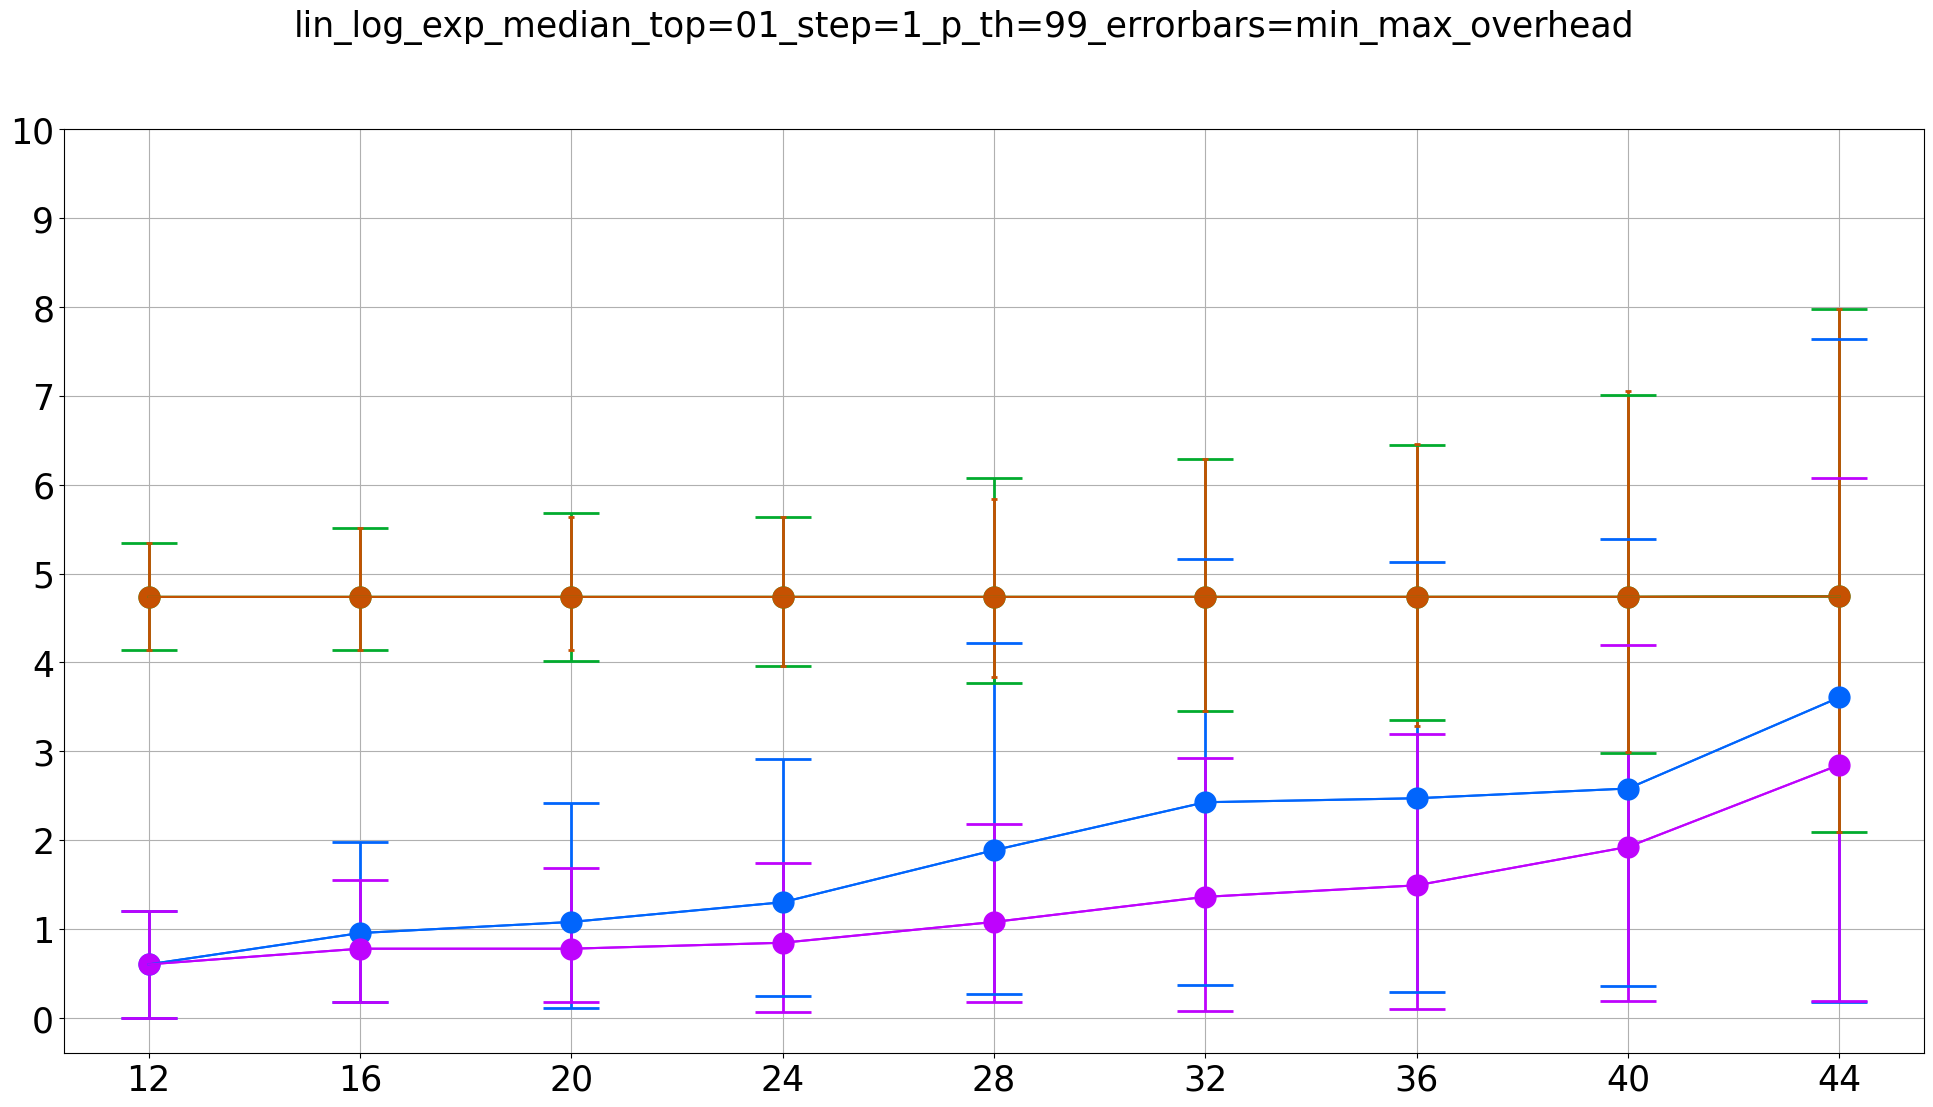

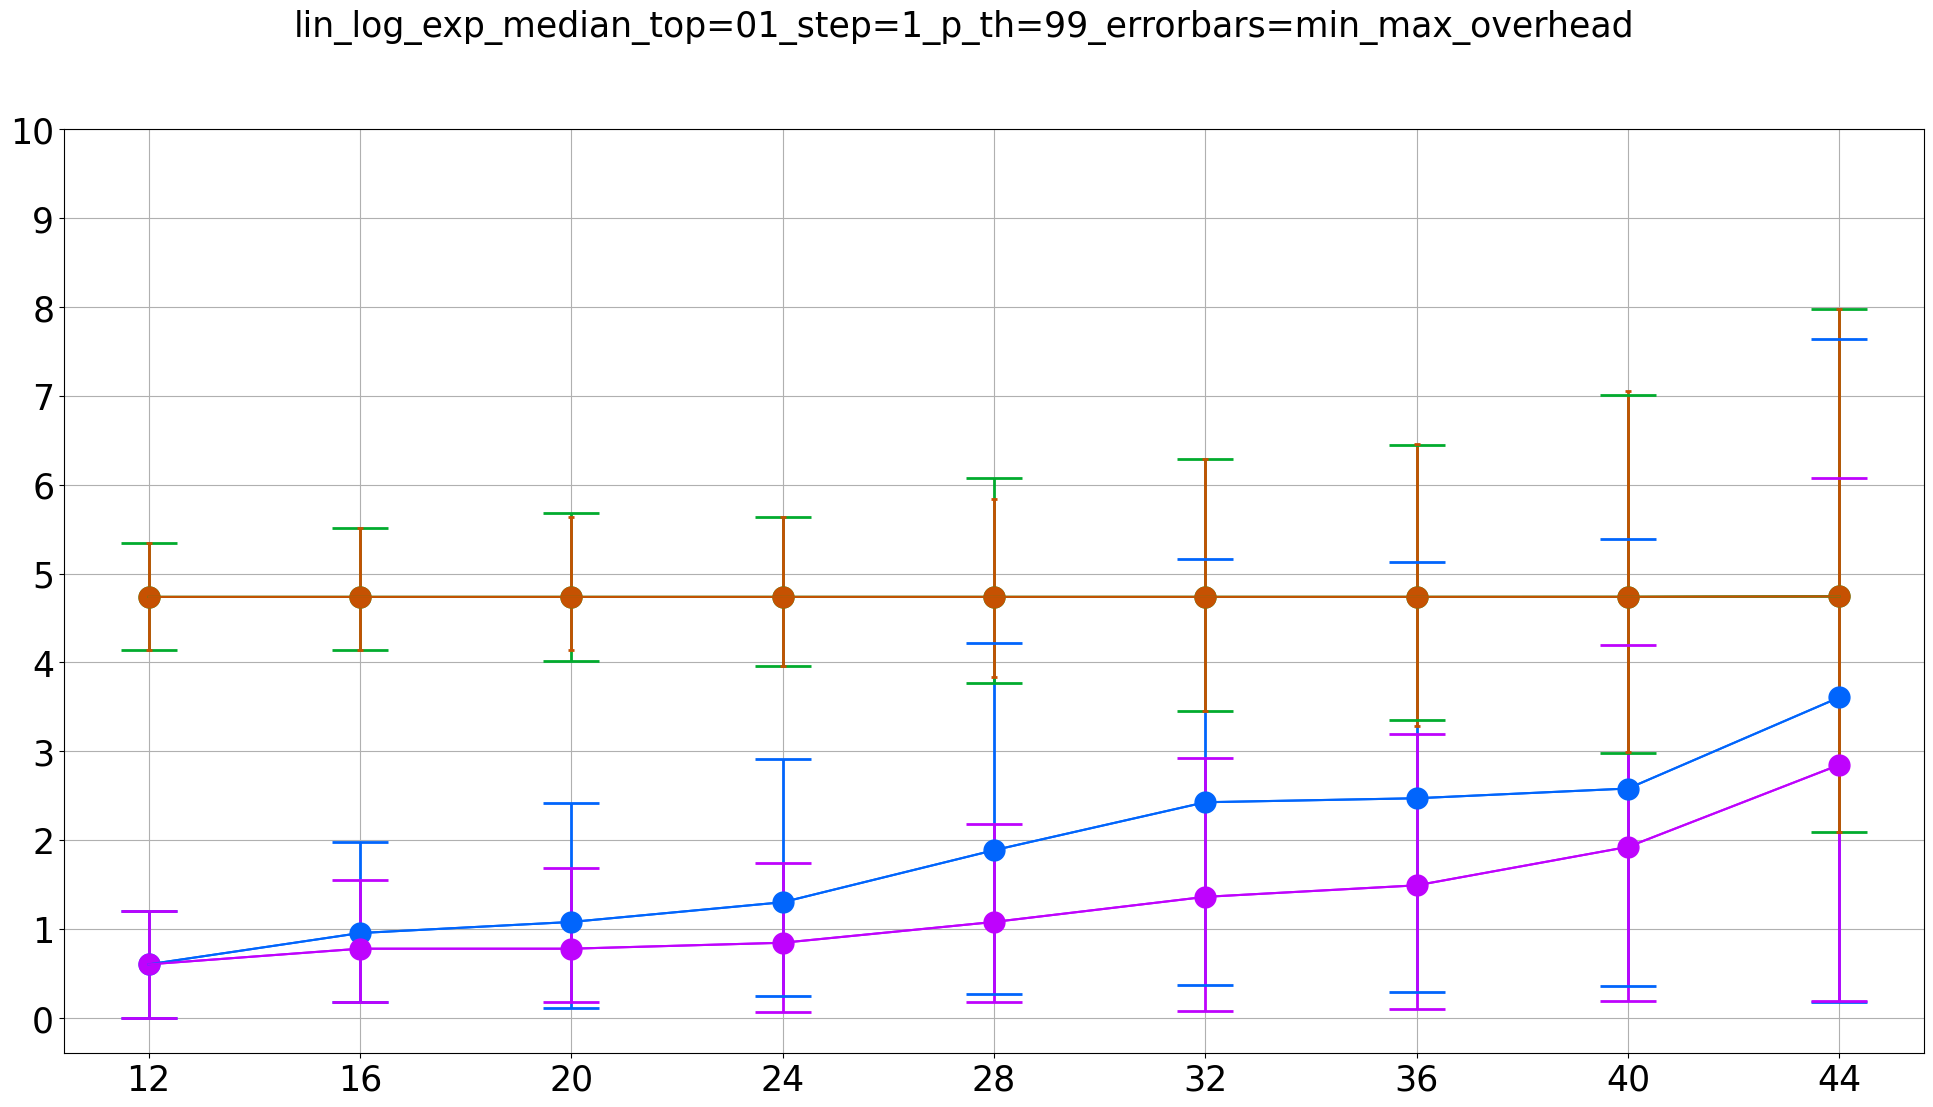

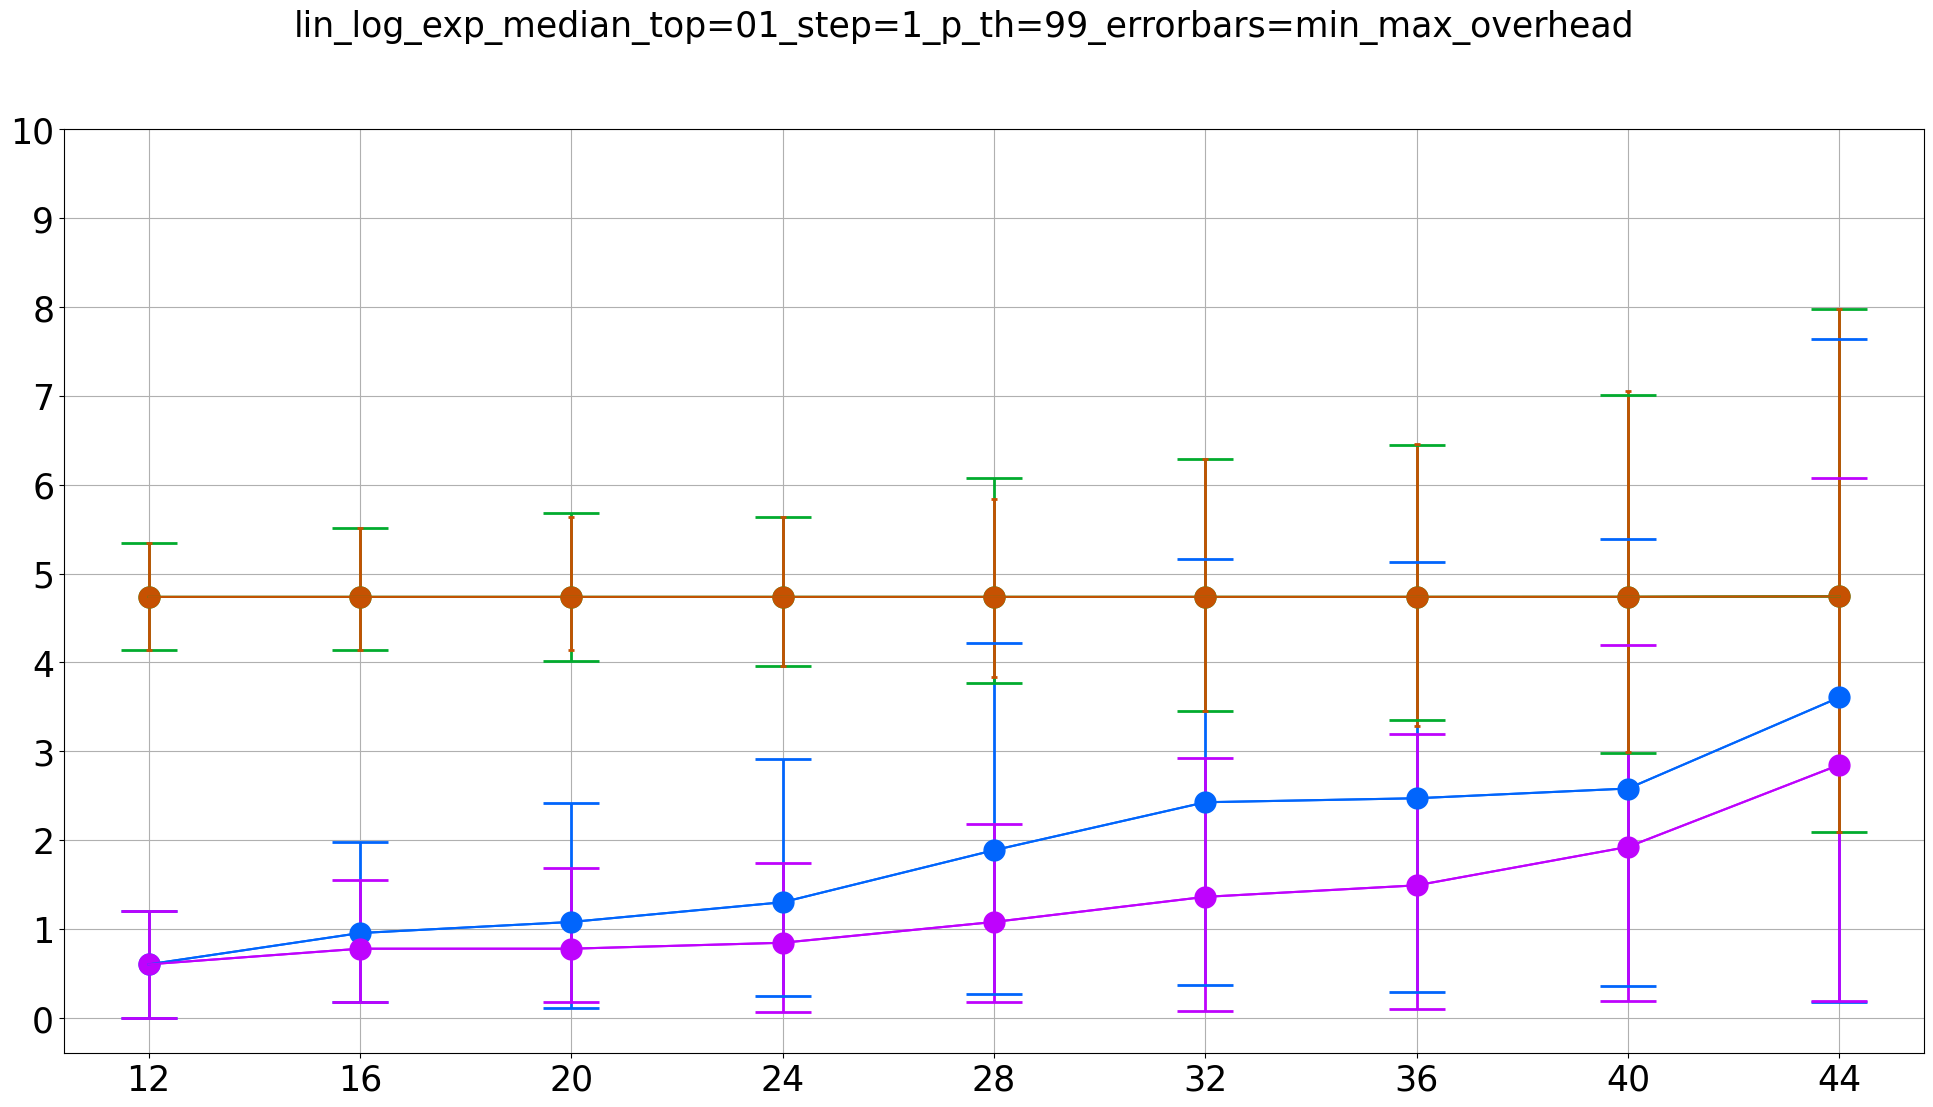

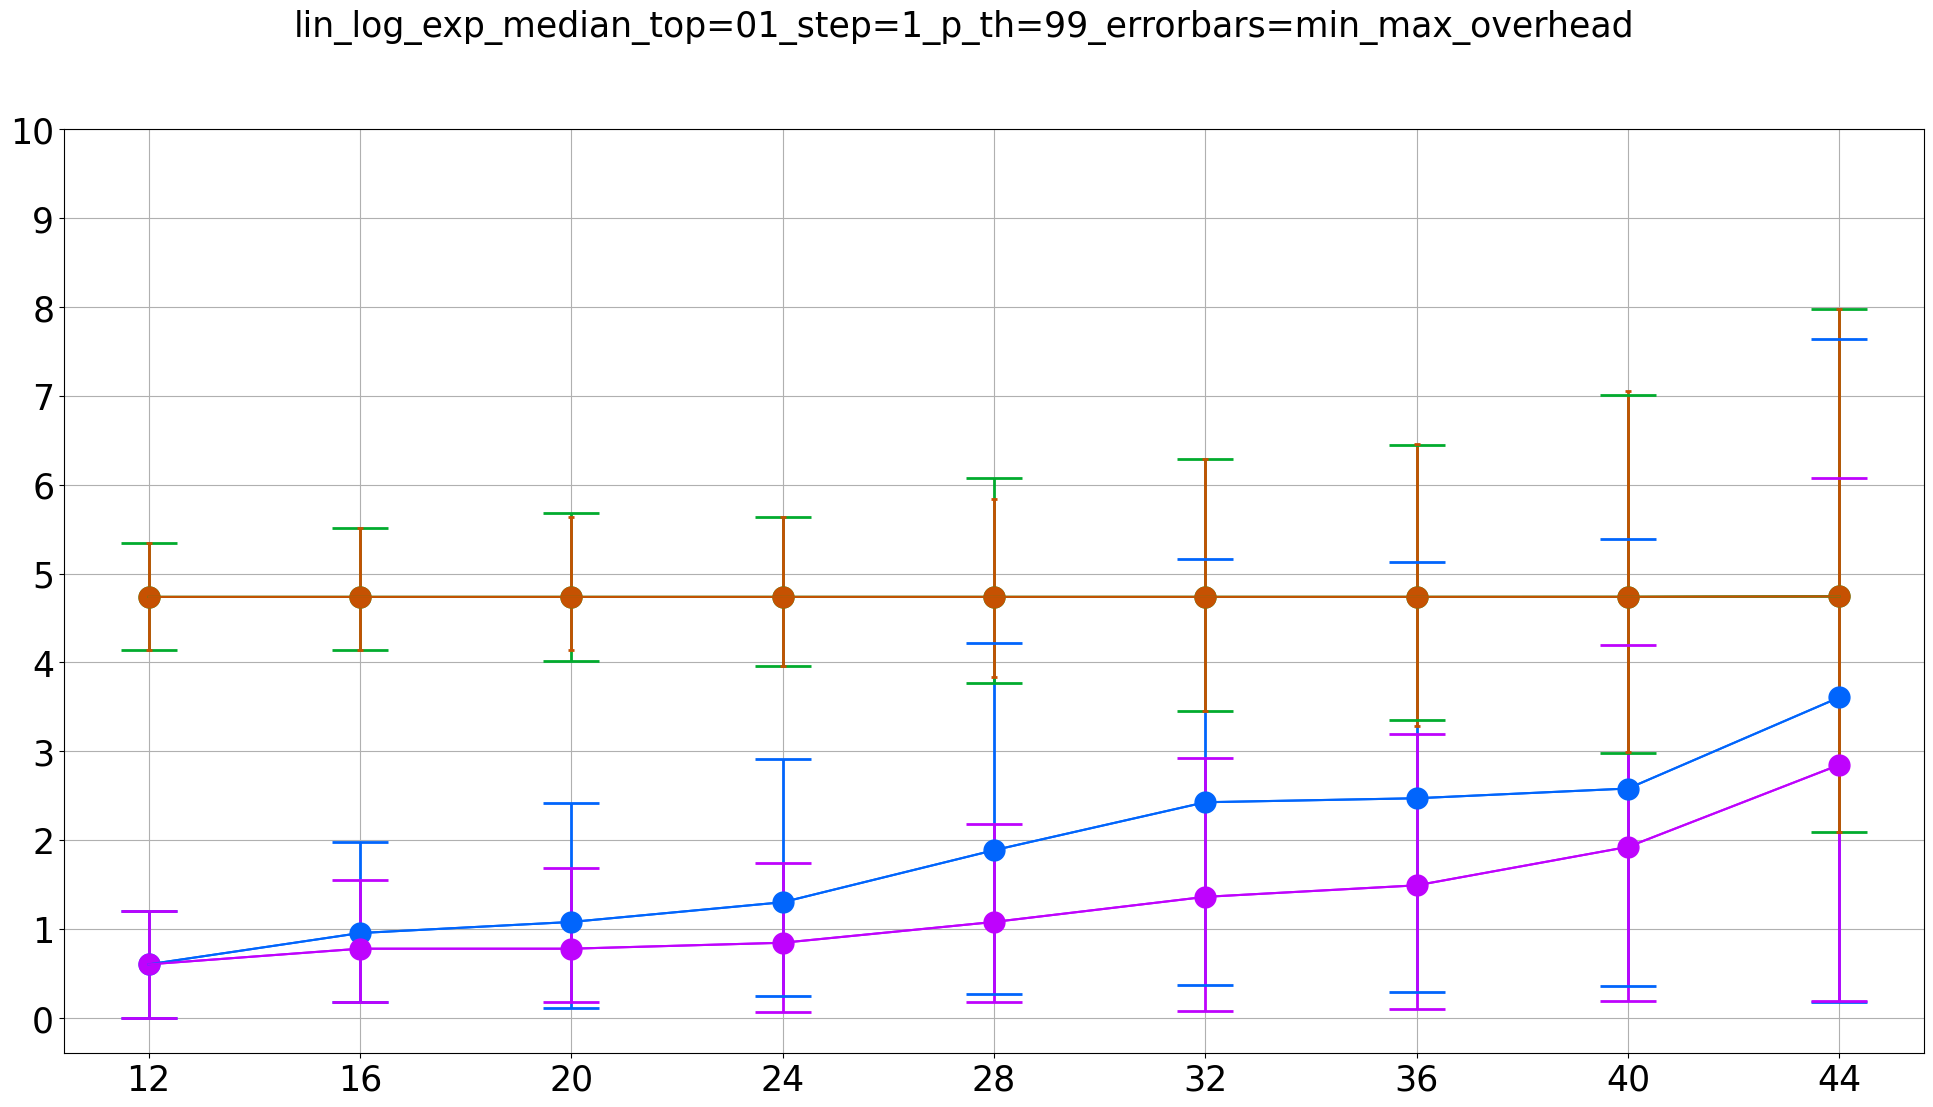

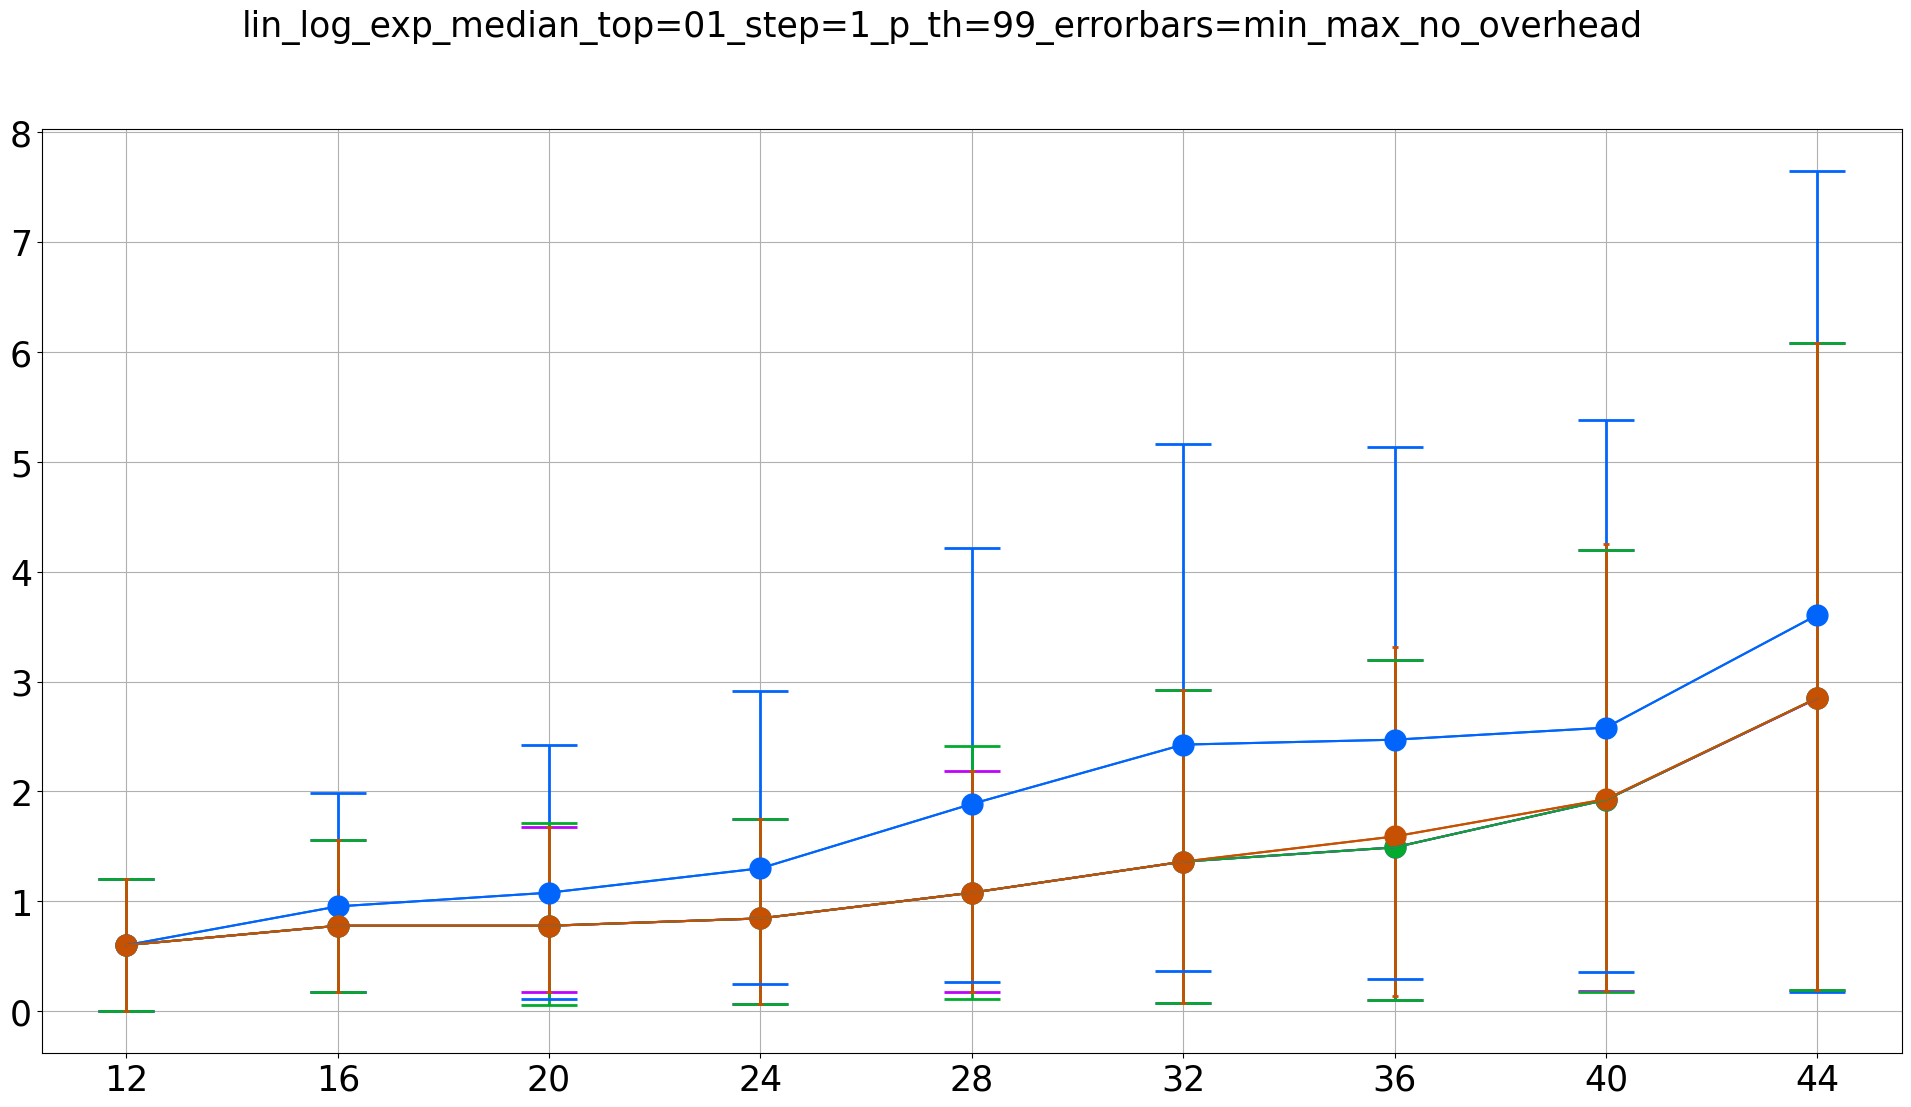

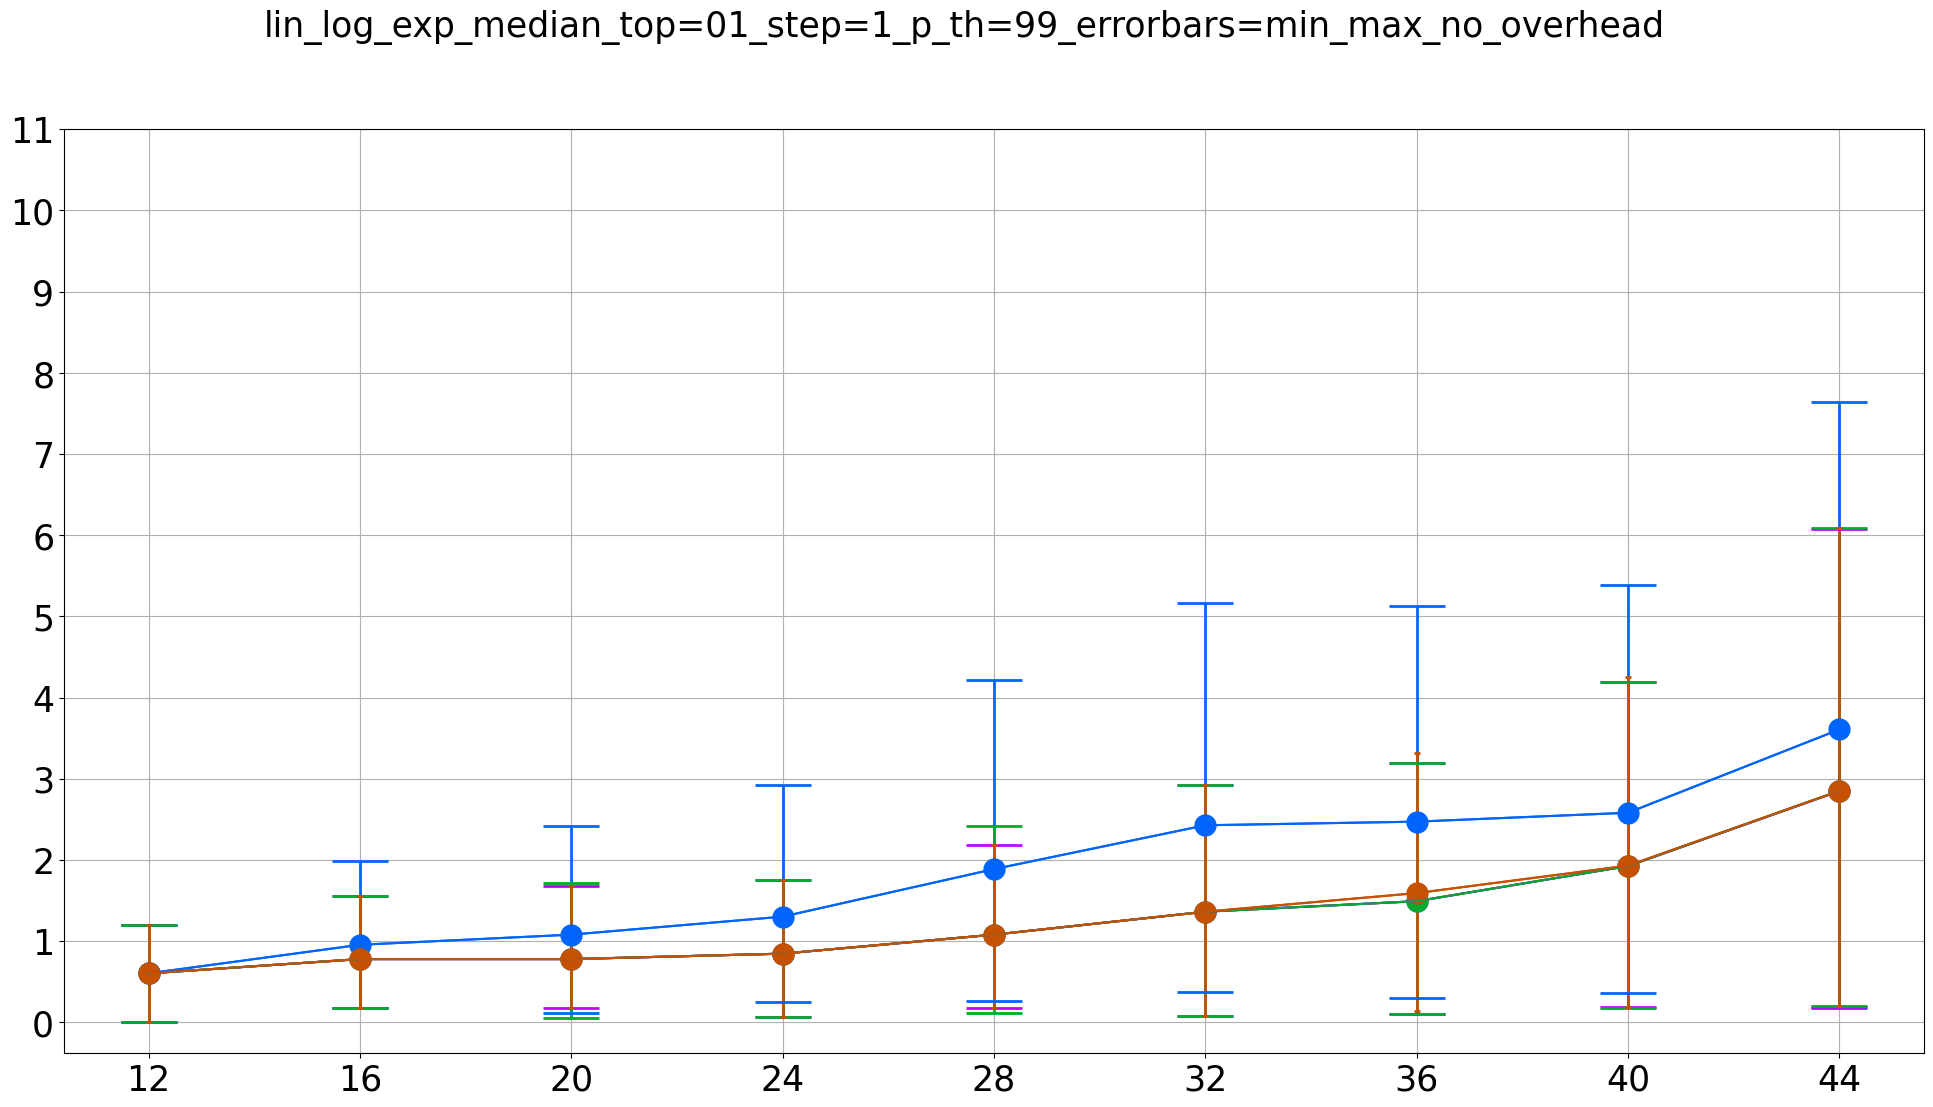

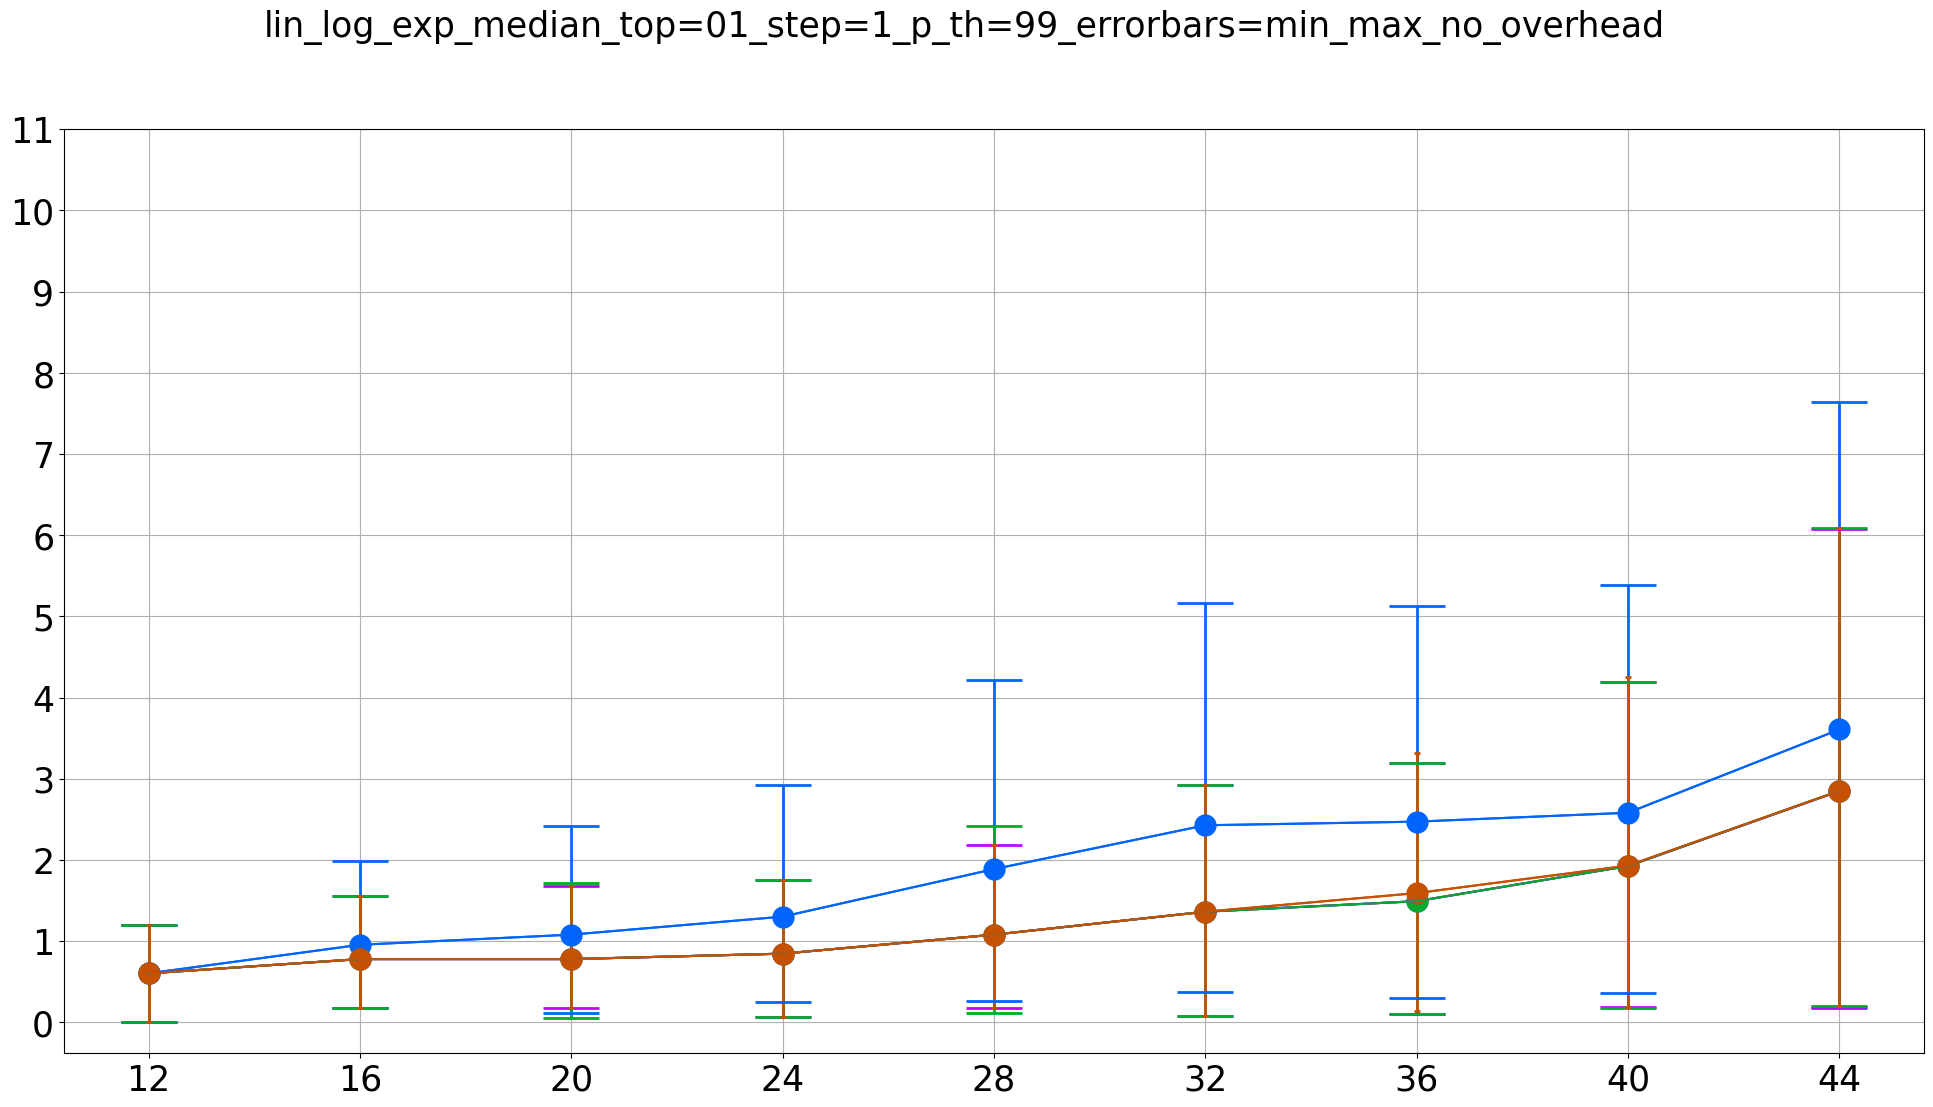

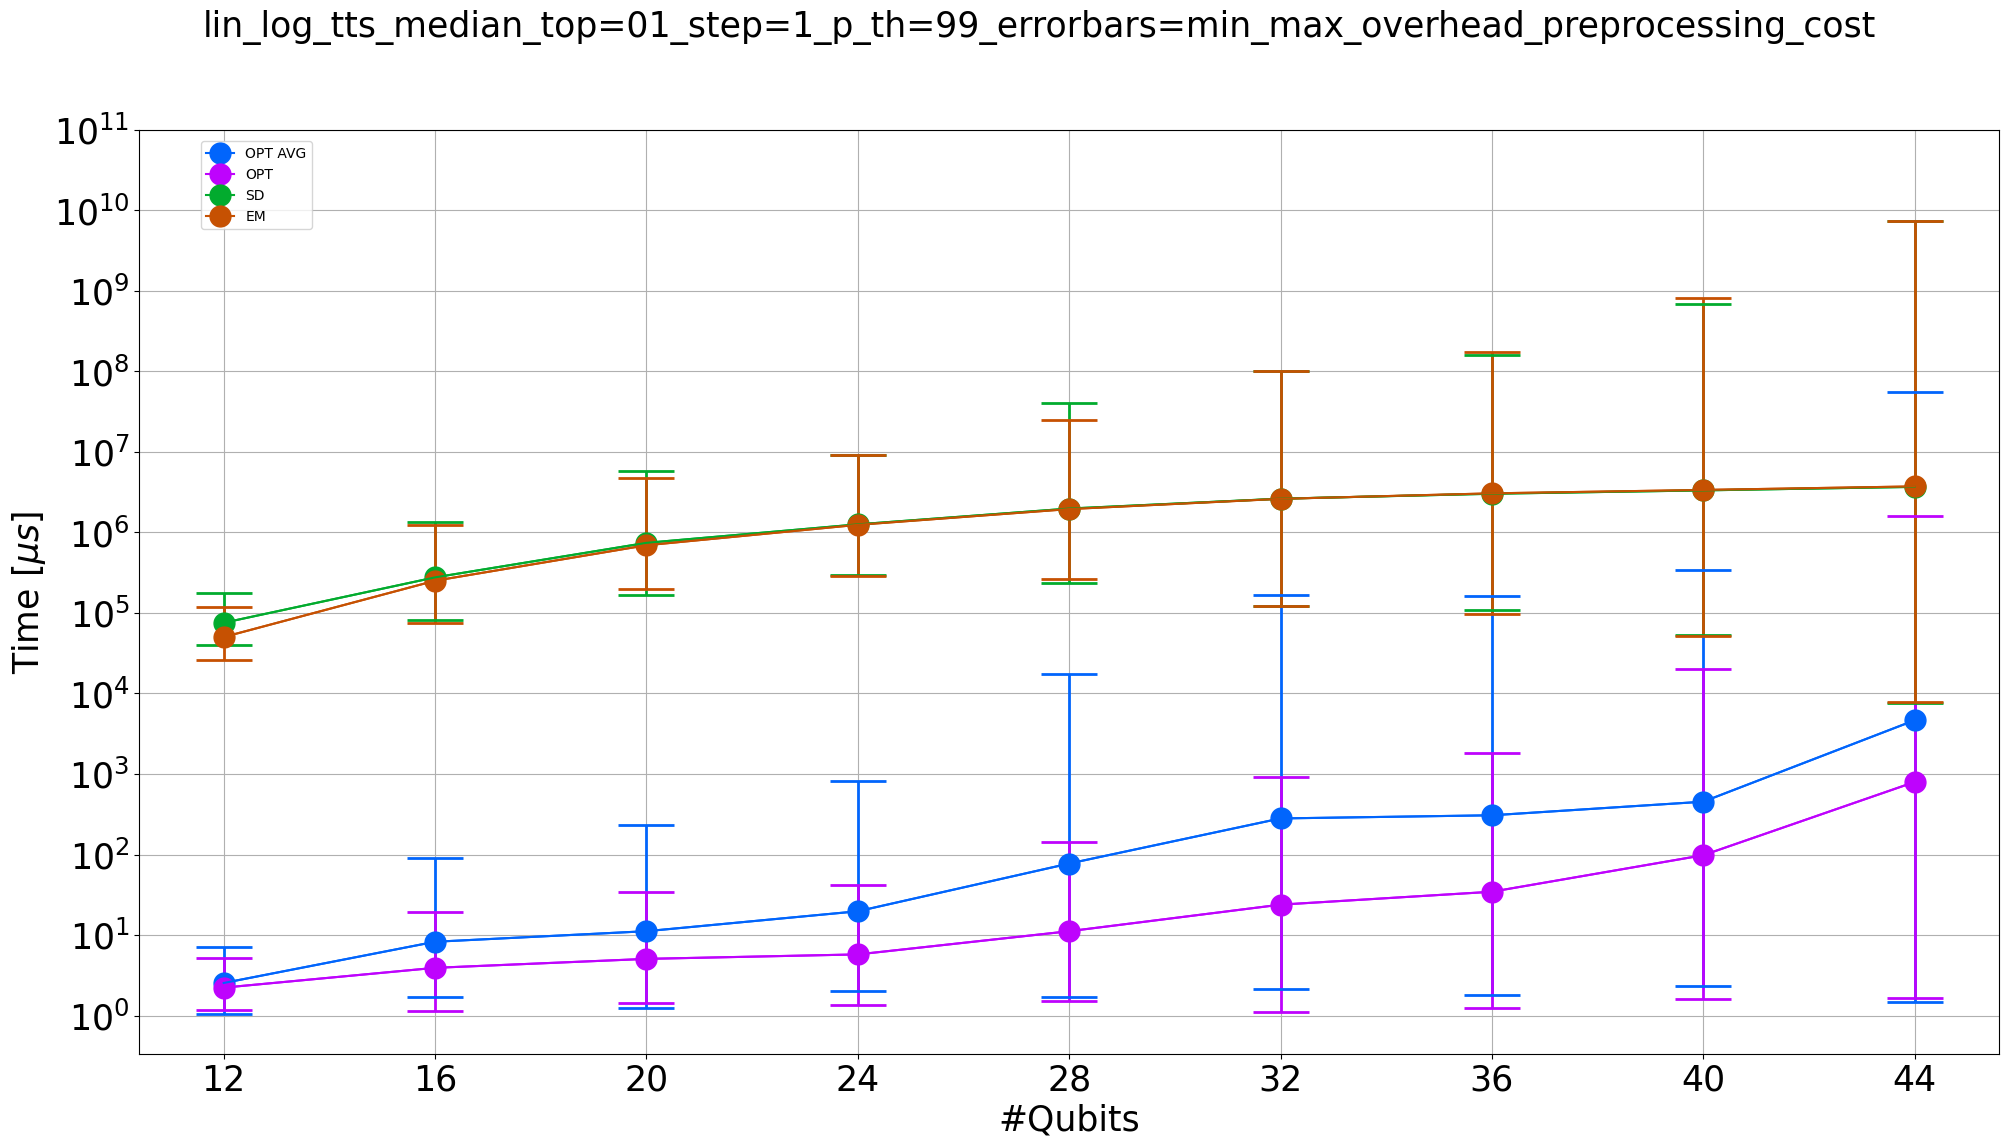

({'stoch': {'mean': [1.4437000000000002,
    2.1904,
    3.59165,
    5.49285,
    12.4499,
    32.7621,
    35.02605,
    185.8888,
    1063.8114],
   'median': [1.113,
    1.9605000000000001,
    2.7504999999999997,
    2.877,
    6.189500000000001,
    11.934000000000001,
    17.264,
    49.053,
    401.014],
   'std': [0.9793901214531417,
    1.0750077395070234,
    2.554572180914057,
    5.683645118011855,
    13.571230268107604,
    59.46332174534146,
    43.69486545404963,
    408.85821857651337,
    1387.8234761489807],
   'min': [0.9561999999999999,
    1.69435,
    2.19135,
    2.13245,
    4.2227,
    10.7666,
    13.816249999999998,
    31.6369,
    238.43669999999997],
   'max': [1.1846999999999999,
    2.43755,
    3.9433,
    3.66955,
    10.246749999999995,
    19.366049999999998,
    26.20245,
    102.30319999999999,
    1001.3774500000001]},
  'elite': {'mean': [1.2408,
    2.1904,
    3.1841,
    4.68495,
    13.7546,
    32.7621,
    48.32445,
    500170.27065,
    

In [25]:
plot_overheads_stoch_elite()

In [28]:
def plotting_single_key(Nmax,  key_value, f_size = 40, bins = 100,  step = 1, conf = 0.99):
    """
    key_values can are strings that can be: "AVG", "SD" and "EM" for the average, stochastic dominance/optimal and elite mean methods respectively
    """
    
    path = "data_for_plots/"

    NQ = 44
    
    stat_file_name = "statistical_params_NQ=44_4qam_samples=10000.csv"
    problem_number = 9
    

    quantiles_df = pd.read_csv(path +  "Thresholds/exp_qubits=" + str(NQ) + "_sample=10000.csv", index_col = 0)
    stat_values = pd.read_csv(path + stat_file_name, index_col=0)

    eng_prob_df = pd.read_csv(path + "eng_prob_"+ str(key_value) +   ".csv", index_col = 0)


    prob = np.array(eng_prob_df["prob"])
    p0 = prob[0] 
    eng_center = np.array(eng_prob_df["eng"])
    
    
    thresholds = quantiles_df[str(9)].values
    
    Emin = thresholds[0]
    mean = stat_values[str(problem_number)]["mean"]
    width = abs(Emin-mean)

    
    
    
    ber_list = []
    N_list = []
    tts_list = {0: [], 1 : [], 2: [], 3: []}
    icdf_list = []
    N_runs = {0.99 : [], 0.95 : [], 0.90 : [] }
    E_list = []
    conf_list = [0.99, 0.95, 0.90]
    



    for N in range(1,Nmax,step):
        N_list.append(N)
        ber = (BER(N, prob, eng_center)-Emin)/(abs(Emin-mean))
#         tts = confidence_prob(N, prob, eng_center, ber)
        for thr in range(4):
            if thr == 0:
                tts_list[thr].append(1-(1-p0)**N)
            else:
                Eth = thresholds[thr]

                cdf_prob = confidence_prob(N, prob, eng_center, Eth )
#                 print("threshold # = ", thr, " Eth = ", Eth, ", P = ", cdf_prob)
                tts_list[thr].append(cdf_prob)


        icdf = (invCDF(N, prob, eng_center, conf = conf)-Emin)/(abs(Emin-mean))


        ber_list.append(ber)
        icdf_list.append(icdf)

    ber_list = np.array(ber_list)

    fig = plt.figure()
    ax1 = plt.subplot2grid((3,3),(0,0), colspan=2, rowspan=2)
    ax2 = plt.subplot2grid((3,3),(0,2),  rowspan=2, sharey=ax1)

    fig.subplots_adjust(wspace = 0 ) 

    fig.set_figheight(16)
    fig.set_figwidth(24)
    
#             color = 'tab:red'
    ax1.set_xlabel('#N', fontsize = f_size)
#             ax1.set_ylabel(r'$P(E) = 1-(1-F(E))^N$', color=color, fontsize = 20)
    ax1.tick_params(axis='x',  labelsize = f_size)

    target = conf


    

    color = 'tab:blue'
    ax1.set_ylabel("E", color="black", fontsize = f_size)  

    ax1.plot(N_list, ber_list,"-o", color=color, label = r'$\mathbb{E}(E)$')
    ax1.plot(N_list, np.array(icdf_list),"-o", color="black", label = r'$F_X^{-1}(1-(1-0.99)^{1/N})$')
#             ax1.set_ylim([-0.1,1.1])


    ax1.tick_params(axis='y', labelcolor="black", labelsize = f_size)
    ax1.tick_params(axis = "x", labelsize = f_size )


    ax1.axhline(y = 0. ,xmin = 0, xmax = Nmax, c = "navy", ls=":", linewidth=1.5,zorder=0, label = "ground state, "+ r"$E_{1\%}$, "+ r"$E_{5\%}$")
    ax1.axhline(y = 0.01 ,xmin = 0, xmax = Nmax, c = "navy", ls=":", linewidth=1.5,zorder=0)
    ax1.axhline(y = 0.05 ,xmin = 0, xmax = Nmax, c = "navy", ls=":", linewidth=1.5,zorder=0)

#             left, bottom, width, height = [0.7, 0.20, 0.2, 0.2]
#             ax2 = fig.add_axes([left, bottom, width, height])
#             ax2.set_ylabel('Energy')
    ax2.set_xlabel('Probability', fontsize = f_size)
    ax2.tick_params(axis='x',  labelsize = f_size)
#     ticks_x = np.array(list(range(9))) * 0.002
    if key_value == "SD":
        ticks_x = [0, 0.001, 0.003]
    elif key_value == "EM":
        ticks_x = [0, 0.005, 0.01]
    elif key_value == "AVG":
        ticks_x = [0, 0.005, 0.01, 0.015]
    plt.xticks(ticks_x)
#     plt.xticks(list(range(12,45,4)))
#     ax2.set_xticklabels(ticks_x, minor = False)
#             ax2.xticks(np.arange(0))
#             ax2.set_ylim([-0.1,1.1])
    ax2.axhline(y = 0. ,xmin = 0, xmax = Nmax, c = "navy", ls=":", linewidth=1.5,zorder=0)
    ax2.axhline(y = 0.01,  c = "navy", ls=":", linewidth=1.5,zorder=0)
    ax2.axhline(y = 0.05,  c = "navy", ls=":", linewidth=1.5,zorder=0)
    plt.setp(ax2.get_xticklabels()[0], visible = False)
#             ax2.bar(prob,eng_center, width = 1, align = "center", orientation = "vertical")
    eng_norm = (np.array(eng_center)-Emin)/(abs(Emin-mean))
#             ax2.barh(eng_center, prob, height = 40, align = "center")
#             print(len(prob), len(eng_center))
#             print(eng_norm, eng_center)
#             print(prob)
    height_norm = 1*abs(min(eng_norm)-max(eng_norm))/bins
    ax2.barh(eng_norm, prob, height = height_norm, align = "center")
#             setp(ax2, yticklabels=[])
    plt.setp(ax2.get_yticklabels(), visible=False)


    fig.subplots_adjust(hspace=0)
    # otherwise the right y-label is slightly clipped

    # These are in unitless percentages of the figure size. (0,0 is bottom left)
    title = "Exp_value_NQ=" + str(NQ) + "_method=" + str(key_value)  + "_bins=" + str(bins) + "_Emin = " + str(Emin)
#             fig.suptitle(title, fontsize = 15)
    fig.legend(loc=(0.3, 0.7), prop = {"size" : f_size-5} )



    path = "plots/single_keys/"
    if not os.path.exists(path):
        os.makedirs(path)
    fig.savefig(path + title + "_N=" + str(Nmax) + "_step="+ str(step) + "_" + str(np.round(conf,2)) +  ".pdf", bbox_inches='tight') 

    plt.show()
    plt.clf()
    plt.close(fig)

    fig, ax = plt.subplots()

    fig.set_figheight(16)
    fig.set_figwidth(24)
    color = 'tab:red'
    ax.set_xlabel('#N', fontsize = f_size)
    ax.set_ylabel(r'$P(E) = 1-(1-F(E))^N$',  fontsize = f_size)
    ax.tick_params(axis='x',  labelsize = f_size)


#     ax.plot(N_list, tts_list[0],"-o", color="red", label = r'$P_{E_0}$')
    ax.plot(N_list, tts_list[2],"--o", color="xkcd:sky blue", label = r'$P_{E_{1\%}}$')
    ax.plot(N_list, tts_list[3],"-o", color="xkcd:red", label = r'$P_{E_{5\%}}$')

    ax.tick_params(axis='y',  labelsize = f_size)
    ax.axhline(target,xmin = 0, xmax = Nmax, c = "black", ls="-", linewidth=0.5,zorder=0, label = "P = 99%")
    fig.legend(loc=(0.7, 0.2), prop = {"size" : f_size-5} )
    title = "conf_prob_NQ=" + str(NQ) + "_method=" + str(key_value) + "_bins=" + str(bins) + "_Emin = " + str(Emin)
    fig.savefig(path + title + "_N=" + str(Nmax) + "_step="+ str(step) + "_" + str(np.round(conf,2)) +  ".pdf", bbox_inches='tight') 
    plt.clf()
    plt.close(fig)
       


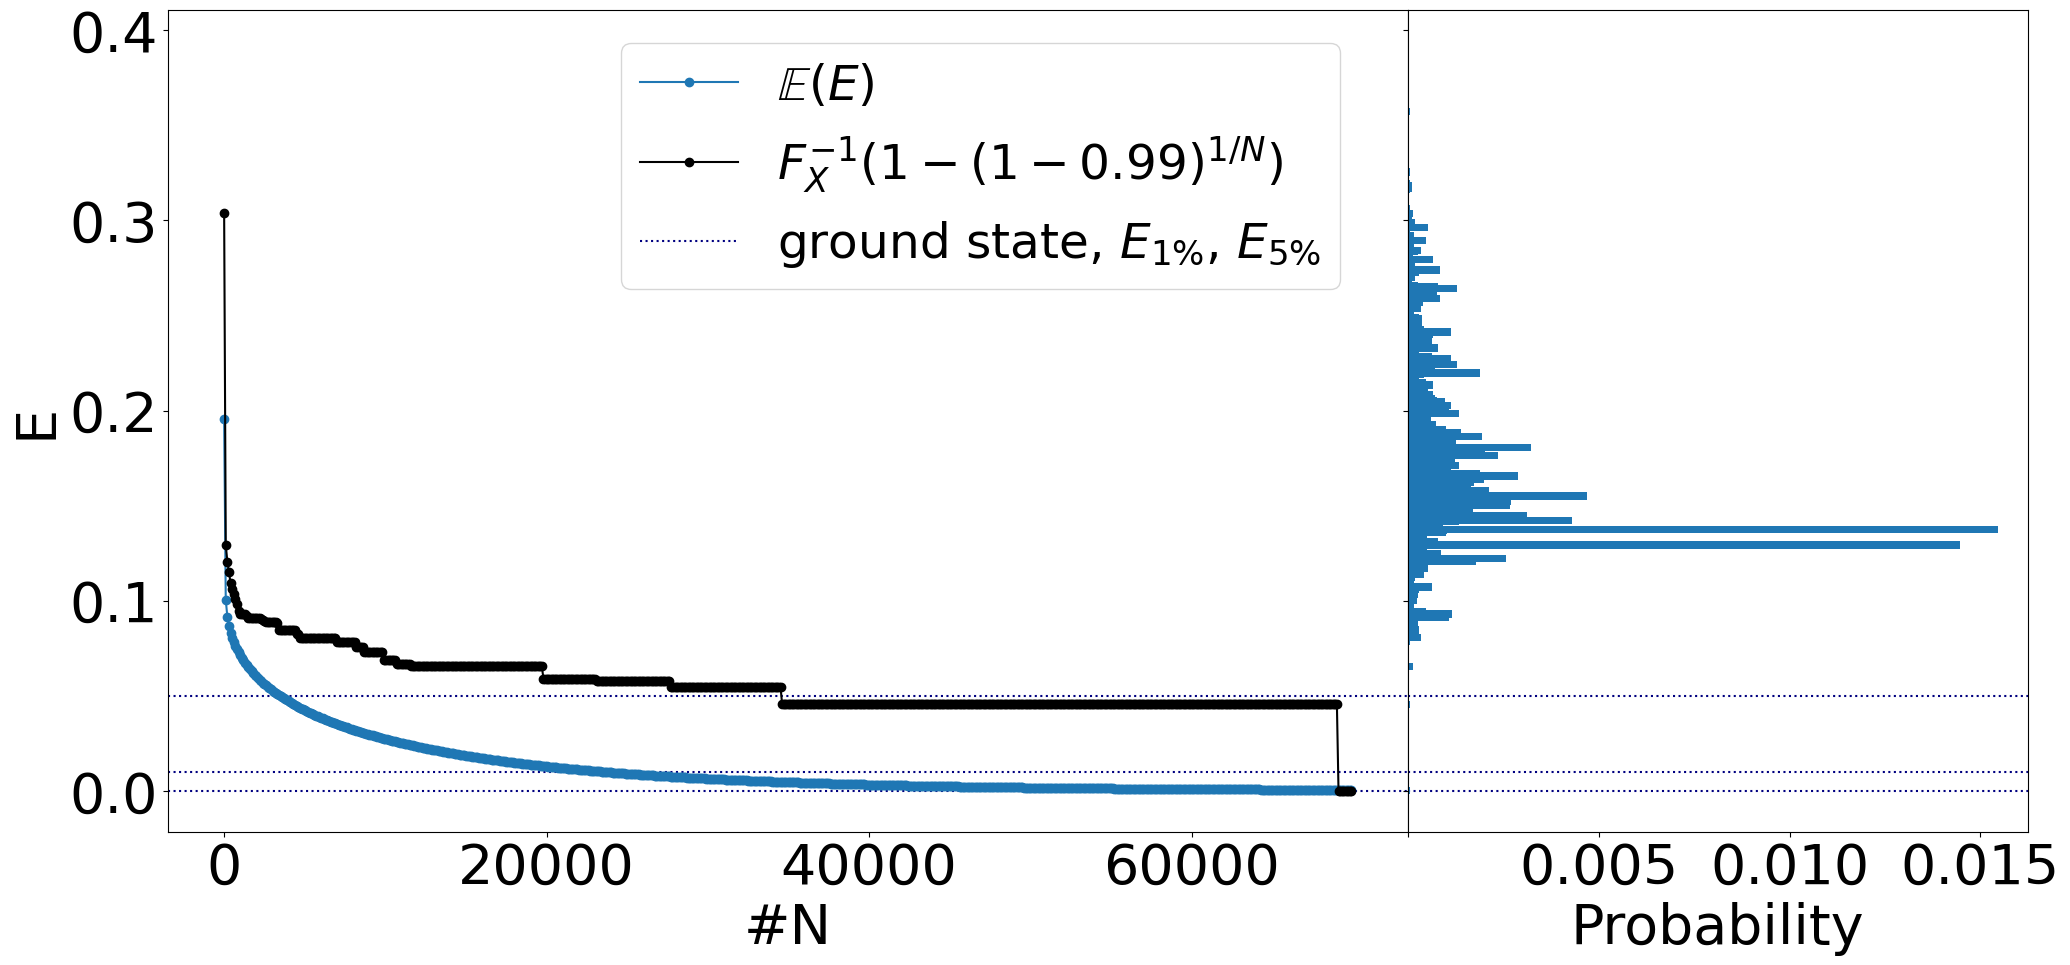

In [29]:
plotting_single_key(70000,  "AVG",   step = 100, conf = 0.99)

In [32]:
def plotting_single_key_runs( key_value,  f_size = 40):
    """
    key_values can are strings that can be: "AVG", "SD" and "EM" for the average, stochastic dominance/optimal and elite mean methods respectively
    """
        
    path = "data_for_plots/"

    NQ = 44
    
    stat_file_name = "statistical_params_NQ=44_4qam_samples=10000.csv"
    problem_number = 9
    

    quantiles_df = pd.read_csv(path +  "Thresholds/exp_qubits=" + str(NQ) + "_sample=10000.csv", index_col = 0)
    stat_values = pd.read_csv(path + stat_file_name, index_col=0)

    eng_prob_df = pd.read_csv(path + "eng_prob_"+ str(key_value) +   ".csv", index_col = 0)


    prob = np.array(eng_prob_df["prob"])
    p0 = prob[0] 
    eng_center = np.array(eng_prob_df["eng"])
    
    
    thresholds = quantiles_df[str(9)].values
    
    Emin = thresholds[0]
    mean = stat_values[str(problem_number)]["mean"]
    width = abs(Emin-mean)

    
    
    
    ber_list = []
    N_list = []
    tts_list = {0: [], 1 : [], 2: [], 3: []}
    icdf_list = []
    N_runs = {0.99 : [], 0.95 : [], 0.90 : [] }
    E_list = []
    conf_list = [0.99, 0.95, 0.90] 
    

    
    for e in range(1, 200):
        E = 0.001 * e
        E_th = Emin + E * width
        E_list.append(E)
        if e % 25 == 0:
            print(e, E, E_th)
        for c in conf_list:
            N_runs[c].append(runs(E_th, c, prob, eng_center))
            
    path = "plots/single_keys/"
    if not os.path.exists(path):
        os.makedirs(path)

    fig, ax = plt.subplots()

    fig.set_figheight(16)
    fig.set_figwidth(24)
    color = 'tab:red'
    ax.set_xlabel('E', fontsize = f_size)
    ax.set_ylabel(r'$N(E,c) = \frac{\log(1-c)}{\log(1-F_X(E))}$',  fontsize = f_size)
    ax.tick_params(axis='x',  labelsize = f_size)


    ax.plot(E_list, N_runs[0.99],"-o", color="red", label = r'$c = 0.99\%$')
    ax.plot(E_list, N_runs[0.95],"--o", color="xkcd:sky blue", label = r'$c = 0.95\%$')
    ax.plot(E_list, N_runs[0.90],"-o", color="xkcd:puke green", label = r'$c = 0.90\%$')

    ax.tick_params(axis='y',  labelsize = f_size)
#     ax.axhline(target,xmin = 0, xmax = Nmax, c = "black", ls="-", linewidth=0.5,zorder=0, label = "P = 99%")
    fig.legend(loc=(0.75, 0.3), prop = {"size" : f_size-5} )
    title = "runs_NQ=" + str(NQ) + "_method=" + str(key_value) +  "_Emin = " + str(Emin)
    fig.savefig(path + title +    ".pdf", bbox_inches='tight') 
    plt.show()
    plt.clf()
    plt.close(fig)

25 0.025 -734.4003756119761
50 0.05 -710.1655112239519
75 0.075 -685.9306468359277
100 0.1 -661.6957824479035
125 0.125 -637.4609180598794
150 0.15 -613.2260536718553
175 0.17500000000000002 -588.9911892838311


<Figure size 640x480 with 0 Axes>

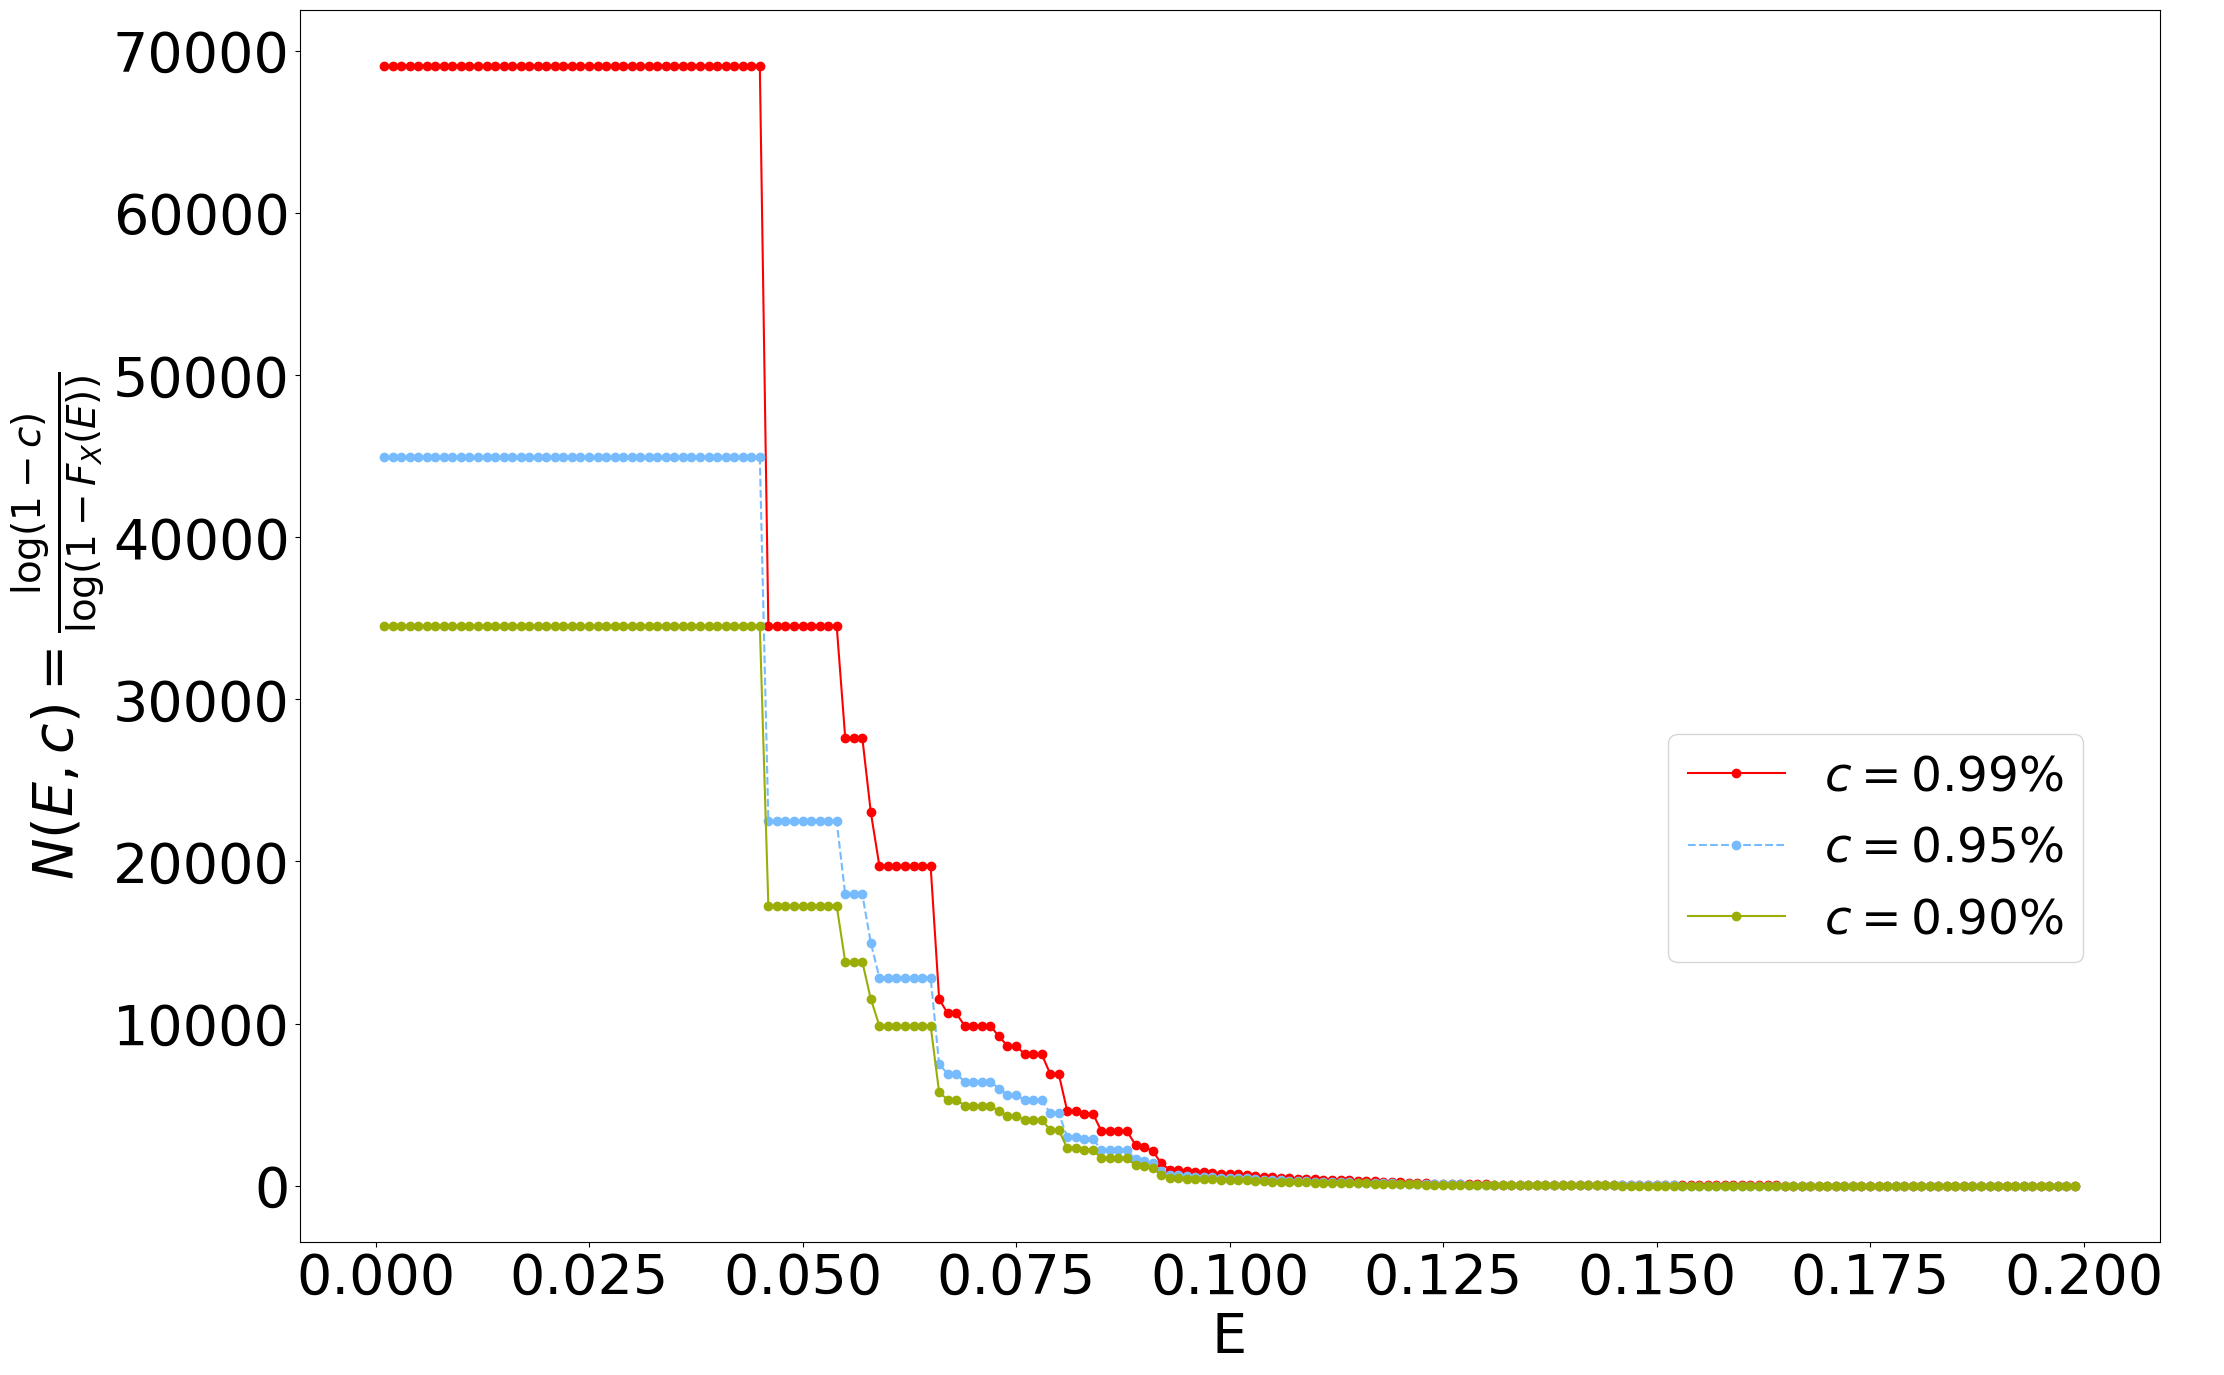

In [33]:
plotting_single_key_runs( "AVG")

In [34]:
def plotting_prob_succ(NQ):
    df_res_opt = pd.read_csv("data_for_plots/prob_succ_NQ="+str(NQ)+"_Nmax=6000_style=opt.csv", index_col = 0)
    df_res_avg = pd.read_csv("data_for_plots/prob_succ_NQ="+str(NQ)+"_Nmax=6000_style=avg.csv", index_col = 0)
    df_res_fixed = pd.read_csv("data_for_plots/prob_succ_NQ="+str(NQ)+"_Nmax=6000_style=[3.0, 0.27].csv", index_col = 0)
    
    fig, ax = plt.subplots()

    fig.set_figheight(16)
    fig.set_figwidth(24)
    ax.set_xlabel('#N', fontsize = 25)
    ax.set_ylabel(r'$\mathbb{E}(Q_N)$',  fontsize = 25)
    ax.tick_params(axis='x',  labelsize = 25)
    
    if not os.path.exists("plots/"):
        os.makedirs("plots/")

    ax.tick_params(axis='y',  labelsize = 25)
    ax.axhline(0.99, c = "black", ls="--", linewidth=2.5,zorder=0, label = "P = 99%")
    ax.plot(df_res_opt["runs"], df_res_opt["prob"], c = 'xkcd:bright purple', label = "OPT", linewidth= 5.0)
    ax.plot(df_res_avg["runs"], df_res_avg["prob"], "--", c = 'xkcd:bright blue',label = "AVG", linewidth= 5.0)
    ax.plot(df_res_fixed["runs"], df_res_fixed["prob"], c = 'xkcd:grass green',label = "Jf=3.0, Sp=0.27", linewidth= 5.0 )
#     ax.xaxis.grid(True)
    ax.grid(True)
    fig.legend(loc=(0.8, 0.2))
    fig.savefig("plots/opt_avg_fixed_prob_succ_NQ=" + str(NQ) + "_Nmax=" + str(6000) +  ".pdf", bbox_inches='tight') 
    plt.show()

<Figure size 640x480 with 0 Axes>

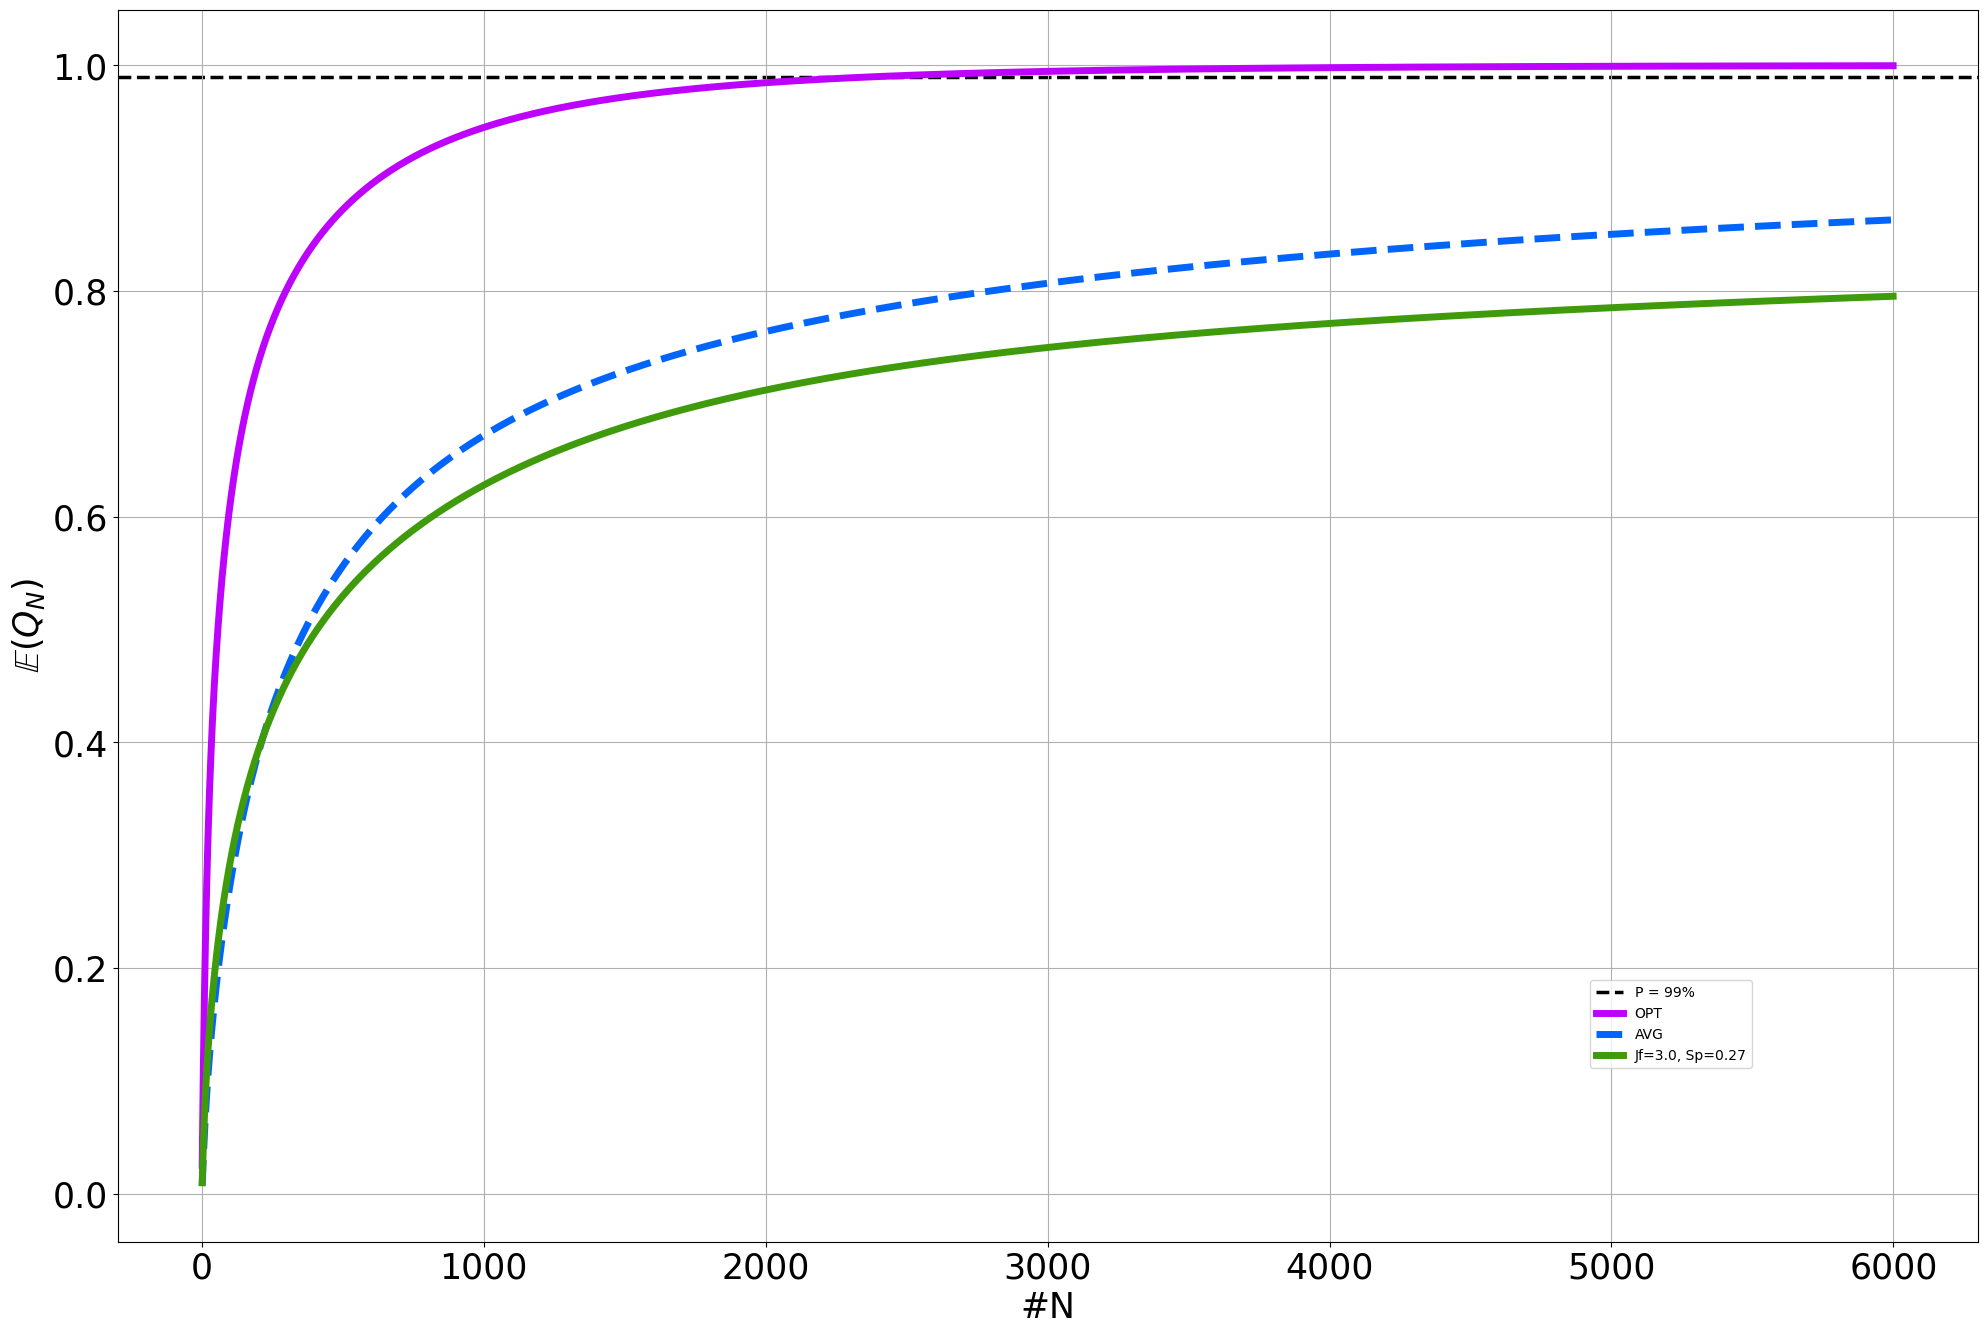

In [35]:
plotting_prob_succ(44)